# Describing model predictions, using SHAP values and SHAP interactions

[Representing categorical features as one-hot encoded features in the model, and as two feaures for the SHAP values: 1. the effect from the hospital they attended, and 2. the effect from not attending the rest]

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebooks (03_xgb_combined_shap_key_features.ipynb) we saw that a feature with the same value in multiple instances (such as all of the patients that attend hospital A), the feature (Hospital A) does not necessarily have the same SHAP value in all of those instances. This means that the feature value alone is not a clear indication of the impact it will have on the prediction - this is due to there being feature interactions, such that SHAP values for a feature are influenced by the other feature values. This means that SHAP values are instance dependent (as they are also capturing the interactions between pairs of feature values). The SHAP values therefore are in turn made up of a main effect (what is due to the feature value, the standalone effect) and also the interactions with the other features (a value per feature pairings).

Also seen in notebook 03a that some hospitals have same value for all instances. That SHAP value when not attend hosptial is near to zero, and when do attend it's a larger value.

Here we explore the SHAP interations.

[Note: In this notebook we will refer to the parts of the SHAP value consistently as base value, main effect, and interactions, where the term SHAP feature value refers to the sum of the main effect and interactions].

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we fit an XGBoost model to the SAMueL dataset, to predict whether a patient recieves thrombolysis from the values of eight features. We calculate the SHAP values (base, main effect and feature interactions) of this fitted model and show the most useful way (that we have found) to present all of these values in order to gain the most insight into how the model is working. At present this is using a grid of SHAP dependency plots.

This notebook is based on the blog https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

## Model and data

XGBoost model was trained on all of the data (no test set used). The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (0 = No, 1 = Yes)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Stroke team: Represented as one-hot encoded features

And one target feature:
* Thrombolysis: Did the patient recieve thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data to predict whether patient gets thrombolysis
* Calculate the SHAP main effect and SHAP interaction values
* Understand the SHAP main effect and SHAP interaction values
* Find the best way to display these values in order to gain the most insight into the relationships that the model is using

## Observations

* SHAP interactions are awesome! 
* Viewing them as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset.

## Import modules

In [167]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import os
import pickle

# So can take deep copy
import copy

from os.path import exists
import json

## Create output folders if needed

In [168]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [169]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

In [170]:
data_loc = '../data/kfold_5fold/'

In [171]:
# Initialise empty lists
train_data, test_data = [], []

# Read in the names of the selected features for the model
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in training set, restrict to chosen features, rename titles, & store
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]
    train.rename(columns=feature_name_dict, inplace=True)
    train_data.append(train)
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=feature_name_dict, inplace=True)
    test_data.append(test)

For this exercise, train the model using all the data. Join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

Set "ignore_index = True" to reset the index from 0 to (n-1), otherwise get duplicate values in the index

In [218]:
data = pd.concat(test_data, ignore_index=True)

Check the final rows index values run up to the number of rows in the dataframe

In [219]:
data.head(-5)

Arrival-to-scan time  Infarction  Stroke severity  Precise onset time  \
0                      17.0           1             14.0                   1   
1                      25.0           1              6.0                   1   
2                     138.0           1              2.0                   1   
3                      21.0           0             11.0                   1   
4                       8.0           1             16.0                   1   
...                     ...         ...              ...                 ...   
88782                  57.0           1             18.0                   0   
88783                  19.0           1             14.0                   1   
88784                  22.0           1             20.0                   1   
88785                  25.0           1             20.0                   1   
88786                   9.0           1              3.0                   1   

       Prior disability level Stroke team  Use of AF anticoagulents  \
0                           0  TXHRP7672C                         0   
1                           0  SQGXB9559U                         0   
2                           0  LFPMM4706C                         0   
3                           0  MHMYL4920B                         0   
4                           0  EQZZZ5658G                         0   
...                       ...         ...                       ...   
88782                       4  QWKRA8499D                         0   
88783                       0  SQGXB9559U                         0   
88784                       0  KZKEZ2257Z                         0   
88785                       0  QOAPO4699N                         0   
88786                       3  PAYNN3649Z                         0   

       Onset-to-arrival time  Thrombolysis  
0                      186.0             1  
1                       71.0             1  
2                       67.0             0  
3                       86.0             0  
4                       83.0             1  
...                      ...           ...  
88782                   93.0             0  
88783                  119.0             1  
88784                   69.0             1  
88785                   54.0             0  
88786                   93.0             0  

[88787 rows x 9 columns]

## Fit XGBoost model

Fit XGBoost model

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [220]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [221]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


## One hot encode hospitals

In [222]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_combined = X.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

## Fit XGBoost model

We will fit a model to all of the data (rather than train/test splits used to assess accuracy).

In [176]:
#model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
model = XGBClassifier(random_state=42)
model.fit(X, y)

[23:23:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Get the predictions for each patient (in terms of the classification, and the probability of being in either class)

In [177]:
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

Calculate the models accuracy

In [178]:
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.865


## Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [179]:
%%time

# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/12a_xgb_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Set up method to estimate SHAP values for tree models & ensembles of trees
    explainer = shap.TreeExplainer(model)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

# Get SHAP values

filename = f'./output/12a_xgb_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values = pickle.load(filehandler)
else:
    # Get SHAP values
    shap_values = explainer(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values , filehandler)

CPU times: user 1.75 s, sys: 71.6 ms, total: 1.82 s
Wall time: 230 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [180]:
shap_values[0]

.values =
array([ 8.2099646e-01,  4.5632765e-01,  9.2364997e-01,  4.7511780e-01,
        4.1019037e-01,  1.7618416e-01, -2.9228532e-01,  4.2540240e-04,
       -4.5442237e-03,  2.1325464e-03,  0.0000000e+00, -2.5729829e-04,
        1.8422068e-03,  4.8460613e-04, -3.8267849e-03, -4.2835288e-04,
       -2.3528575e-03,  1.8719657e-03, -1.0490450e-05,  4.5265248e-03,
       -4.0580845e-03, -7.9108897e-04,  5.2862233e-03,  2.6880822e-03,
       -6.3512926e-03,  0.0000000e+00,  5.6895977e-03,  0.0000000e+00,
        7.6561200e-04,  3.1929142e-03,  2.9121309e-05, -4.1155503e-04,
       -1.2902044e-02, -7.7010146e-03, -3.5297940e-05, -3.7926573e-03,
       -5.0153672e-03, -4.8773934e-04,  0.0000000e+00, -1.0628974e-03,
        1.9793636e-03,  8.6649298e-04,  1.1273651e-02,  2.2381998e-03,
       -2.1770147e-03,  2.0553854e-03, -6.5969322e-03,  2.8115187e-03,
        2.9118615e-03,  1.3830408e-03,  4.8573629e-04,  2.5301613e-03,
        9.1632153e-04,  1.1261479e-02,  1.3155100e-04, -1.2778351e-

There is one of these for each instance.

In [181]:
shap_values.shape

(88792, 139)

# SHAP for catgeorical features 

We've seen above that the categorical feature represented as a one-hot encoded feature have a SHAP value for each of the one-hot encoded features.

Looking at them in isolation gives us the contribution of each in respect to the feature value.

As SHAP values are additive, we have the option of joining them together (summing each of the one-hot features) to give us the overall contribution of the whole feature, to be described as "the contribution of attending this hospital, and not any of the others". This is in notebook 12c.

Here we will keep the SHAP value separate for "the contribution for attending this hospital", and sum the remaining OHE features, to be described as "the contribution from not attending the others".shap_attended_hospital = pd.series()

In [182]:
X.columns

Index(['Arrival-to-scan time', 'Infarction', 'Stroke severity',
       'Precise onset time', 'Prior disability level',
       'Use of AF anticoagulents', 'Onset-to-arrival time', 'team_AGNOF1041H',
       'team_AKCGO9726K', 'team_AOBTM3098N',
       ...
       'team_XKAWN3771U', 'team_XPABC1435F', 'team_XQAGA4299B',
       'team_XWUBX0795L', 'team_YEXCH8391J', 'team_YPKYH1768F',
       'team_YQMZV4284N', 'team_ZBVSO0975W', 'team_ZHCLE1578P',
       'team_ZRRCV7012C'],
      dtype='object', length=139)

In [183]:
# get list of hospital one hot encoded column titles
hospital_columns = X.filter(regex='^team',axis=1).columns
# create list of column index for these hospital column titles
hospital_columns_index = [X.columns.get_loc(col) for col in hospital_columns]
# use this list on teh shap_values as they are in the same order

In [184]:
# get shap values for just the hospitals (as array)
hosp_shap_values = shap_values.values[:,hospital_columns_index]
# put in dataframe with hospital as column title
df_hosp_shap_values = pd.DataFrame(hosp_shap_values, columns = hospital_columns)
df_hosp_shap_values

team_AGNOF1041H  team_AKCGO9726K  team_AOBTM3098N  team_APXEE8191H  \
0             0.000425        -0.004544         0.002133              0.0   
1             0.000688        -0.005805         0.002783              0.0   
2             0.000688        -0.013376         0.003087              0.0   
3             0.000688        -0.003726         0.001795              0.0   
4             0.004662        -0.006233         0.002781              0.0   
...                ...              ...              ...              ...   
88787         0.001531        -0.006718         0.002113              0.0   
88788         0.000873        -0.013248         0.002855              0.0   
88789         0.000873        -0.012151         0.002855              0.0   
88790         0.000688        -0.009239         0.003879              0.0   
88791         0.001136        -0.017307         0.003054              0.0   

       team_ATDID5461S  team_BBXPQ0212O  team_BICAW1125K  team_BQZGT7491V  \
0            -0.000257         0.001842         0.000485        -0.003827   
1            -0.000241         0.000561         0.001729        -0.003741   
2            -0.000339         0.001068         0.001239        -0.006930   
3            -0.000242         0.001189         0.001472        -0.003931   
4            -0.000246         0.000269         0.001709        -0.003418   
...                ...              ...              ...              ...   
88787        -0.000257         0.000536         0.003178        -0.003243   
88788        -0.000408         0.002011         0.000850         0.001256   
88789        -0.001041         0.002186         0.002497        -0.004390   
88790        -0.000254         0.000800         0.001249        -0.006423   
88791        -0.000286         0.001189         0.002106        -0.007242   

       team_BXXZS5063A  team_CNBGF2713O  ...  team_XKAWN3771U  \
0            -0.000428        -0.002353  ...        -0.008792   
1            -0.000399        -0.002662  ...        -0.008971   
2            -0.001318        -0.003079  ...        -0.009635   
3            -0.000377        -0.002434  ...        -0.006474   
4            -0.000390        -0.002434  ...        -0.008897   
...                ...              ...  ...              ...   
88787        -0.000385        -0.002299  ...        -0.007605   
88788        -0.002154        -0.002436  ...        -0.007939   
88789        -0.000966        -0.003161  ...        -0.007050   
88790        -0.000347        -0.003235  ...        -0.007459   
88791        -0.000368        -0.001897  ...        -0.007016   

       team_XPABC1435F  team_XQAGA4299B  team_XWUBX0795L  team_YEXCH8391J  \
0             0.002304         0.001847        -0.004335         0.000242   
1             0.002022         0.002474        -0.004736         0.000242   
2             0.002273         0.003058        -0.004277         0.000110   
3             0.001580         0.002348        -0.002319         0.000242   
4             0.000817         0.001275        -0.002466         0.000242   
...                ...              ...              ...              ...   
88787         0.001053         0.001913        -0.005579         0.000242   
88788         0.002378         0.003379         0.001151         0.000064   
88789         0.002398         0.003426        -0.000370         0.000242   
88790         0.001683         0.004126        -0.003962         0.000242   
88791         0.002273         0.003570        -0.002280         0.000242   

       team_YPKYH1768F  team_YQMZV4284N  team_ZBVSO0975W  team_ZHCLE1578P  \
0             0.000384        -0.000924         0.001592        -0.000849   
1             0.000632        -0.000350         0.001936        -0.002425   
2             0.000421        -0.000350         0.002117        -0.002792   
3             0.000632        -0.000583         0.001853        -0.002212   
4             0.000431        -0.000924         0.002366         0

Surprised to see a hospital (team_APXEE8191H) with only zeros. Is this the case for all instances for this hospital?

Look at histogram for this hospital - all patients have SHAP value of 0 for this hospital.

Number of unique values: 1


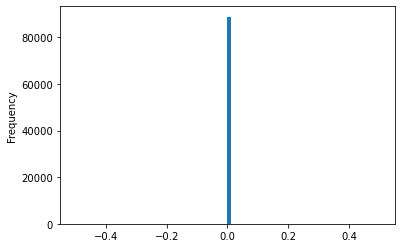

In [240]:
ax = df_hosp_shap_values.team_APXEE8191H.plot.hist(bins=100)
print(f"Number of unique values: {df_hosp_shap_values.team_APXEE8191H.nunique()}")

Do any other hosptials have only 1 unique value? Look at histogram for number of unique SHAP values for each hospital for all patients

In [241]:
print("These hospitals have the same SHAP value for all patients")
for col in hospital_columns:
    if df_hosp_shap_values[col].nunique() == 1:
        print(f"{col}: {df_hosp_shap_values[col].unique()[0]}")

These hospitals have the same SHAP value for all patients
team_APXEE8191H: 0.0
team_EQZZZ5658G: 0.0
team_FCCJC8768V: 0.0
team_HONZP0443O: 0.0
team_JXJYG0100P: 0.0
team_QTELJ8888W: 0.0
team_TXYJJ1019H: 0.0
team_WSFVN0229E: 0.0


The range of unique values for each hosptial


(array([65., 12., 13.,  6.,  6.,  6.,  8.,  7.,  6.,  3.]),
 array([1.00000e+00, 7.26480e+03, 1.45286e+04, 2.17924e+04, 2.90562e+04,
        3.63200e+04, 4.35838e+04, 5.08476e+04, 5.81114e+04, 6.53752e+04,
        7.26390e+04]),
 <BarContainer object of 10 artists>)

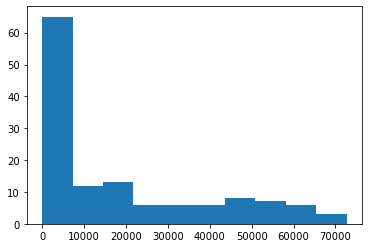

In [247]:
print ("The range of unique values for each hosptial")       
n_unique_per_hosptial = [df_hosp_shap_values[col].nunique() for col in hospital_columns]                         
fig, axes = plt.subplots(1)
axes.hist(n_unique_per_hosptial)

Is there a relationship between number unique shap values, and admission numnbers?

In [248]:
admissions = [X[col].sum() for col in hospital_columns]
n_unique_per_hosptial = [df_hosp_shap_values[col].nunique() for col in hospital_columns]

<AxesSubplot:xlabel='admissions', ylabel='n_unique_per_hosptial'>

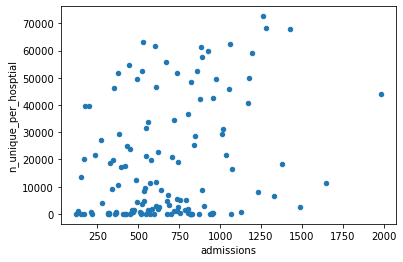

In [251]:
df = pd.DataFrame(admissions, columns=["admissions"])
df["n_unique_per_hosptial"] = n_unique_per_hosptial
df.plot.scatter(x="admissions", y="n_unique_per_hosptial")

What's the difference between the SHAP value for a hospital for the instances that attended it, and those that didn't?

VKKDD9172T. Number of unique values for all patients (attended or not): 72639
Number of patients 88792


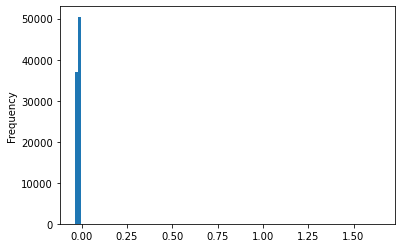

VKKDD9172T. Number of unique values for those patients who attended: 1154
Number of patients 1261


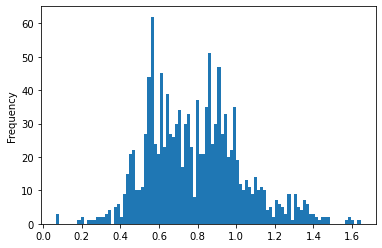

VKKDD9172T. Number of unique values for those patients who did not attended: 71485
Number of patients 87531


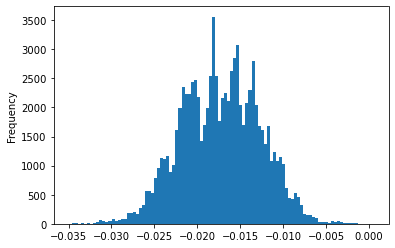

In [252]:
mask1 = X_combined["Stroke team"] == "VKKDD9172T"
shap_values_attend_VKKDD9172T = df_hosp_shap_values["team_VKKDD9172T"][mask1]

mask2 = np.logical_not(mask1)
shap_values_not_attend_VKKDD9172T = df_hosp_shap_values["team_VKKDD9172T"][mask2]

ax = df_hosp_shap_values["team_VKKDD9172T"].plot.hist(bins=100);
print(f"VKKDD9172T. Number of unique values for all patients (attended or not): {df_hosp_shap_values['team_VKKDD9172T'].nunique()}")
print(f"Number of patients {df_hosp_shap_values['team_VKKDD9172T'].shape[0]}")
plt.show()

mask1 = mask1 * 1
s1 = mask1.sum()
ax = shap_values_attend_VKKDD9172T.plot.hist(bins=100);
print(f"VKKDD9172T. Number of unique values for those patients who attended: {shap_values_attend_VKKDD9172T.nunique()}")
print(f"Number of patients {s1}")
plt.show()

mask2 = mask2 * 1
s2 = mask2.sum()
ax = shap_values_not_attend_VKKDD9172T.plot.hist(bins=100);
print(f"VKKDD9172T. Number of unique values for those patients who did not attended: {shap_values_not_attend_VKKDD9172T.nunique()}")
print(f"Number of patients {s2}")
plt.show()

So there's two populations, that can not see in the histogram for all instances.
Those that attend have a higher SHAP value, but there's fewer instances so can not see these values.
Those that do not attend have a low SHAP value, a smaller range of values, but far more instances, so dominats the y axis, but can not see the spread (as the other population has determiens the x axis range).

Better to view as two populations.

In [225]:
df_hosp_shap_values["team_VKKDD9172T"].describe()

count    88792.000000
mean        -0.005801
std          0.099974
min         -0.034956
25%         -0.020593
50%         -0.017124
75%         -0.013723
max          1.644123
Name: team_VKKDD9172T, dtype: float64

In [227]:
df_hosp_shap_values.describe()

team_AGNOF1041H  team_AKCGO9726K  team_AOBTM3098N  team_APXEE8191H  \
count     88792.000000     88792.000000     88792.000000          88792.0   
mean          0.000333        -0.002467         0.000010              0.0   
std           0.007845         0.070291         0.030597              0.0   
min          -0.141289        -0.074127        -0.581330              0.0   
25%           0.000425        -0.013278         0.002098              0.0   
50%           0.000873        -0.008261         0.002247              0.0   
75%           0.001083        -0.004984         0.002913              0.0   
max           0.005109         1.490837         0.004093              0.0   

       team_ATDID5461S  team_BBXPQ0212O  team_BICAW1125K  team_BQZGT7491V  \
count     8.879200e+04     88792.000000     88792.000000     88792.000000   
mean     -4.672110e-07        -0.000809         0.000326         0.000028   
std       5.354509e-03         0.040472         0.021575         0.045684   
min      -1.041217e-03        -1.005339        -0.560755        -0.300049   
25%      -2.861158e-04         0.000799         0.001245        -0.004516   
50%      -2.550984e-04         0.001345         0.001693        -0.002884   
75%      -2.427274e-04         0.001940         0.002445        -0.000836   
max       2.191782e-01         0.002754         0.003866         1.225647   

       team_BXXZS5063A  team_CNBGF2713O  ...  team_XKAWN3771U  \
count     88792.000000     88792.000000  ...     88792.000000   
mean         -0.000685        -0.000225  ...        -0.000564   
std           0.018448         0.050017  ...         0.078670   
min          -0.028611        -0.003963  ...        -0.122732   
25%          -0.001047        -0.002654  ...        -0.009950   
50%          -0.000423        -0.002298  ...        -0.007957   
75%          -0.000375        -0.001819  ...        -0.006049   
max           1.054860         1.701207  ...         1.450462   

       team_XPABC1435F  team_XQAGA4299B  team_XWUBX0795L  team_YEXCH8391J  \
count     88792.000000     88792.000000     88792.000000     88792.000000   
mean          0.000417        -0.000188         0.000140        -0.000045   
std           0.038360         0.036237         0.039386         0.005867   
min          -1.196352        -0.727106        -0.259082        -0.213915   
25%           0.001711         0.002030        -0.004379         0.000099   
50%           0.002237         0.002562        -0.002680         0.000242   
75%           0.002355         0.003138        -0.001143         0.000242   
max           0.002619         0.004912         0.980983         0.000242   

       team_YPKYH1768F  team_YQMZV4284N  team_ZBVSO0975W  team_ZHCLE1578P  \
count     88792.000000     88792.000000     88792.000000     88792.000000   
mean         -0.000090        -0.000040        -0.000174         0.000339   
std           0.010114         0.009594         0.030205         0.028524   
min          -0.224694        -0.039567        -0.821916        -0.316356   
25%           0.000431        -0.000881         0.001490        -0.003676   
50%           0.000461        -0.000392         0.001976        -0.002078   
75%           0.000632        -0.000061         0.002321         0.000749   
max           0.000632         0.349109         0.166003         0.741715   

       team_ZRRCV7012C  
count     88792.000000  
mean         -0.000495  
std           0.049191  
min          -0.973400  
25%           0.002507  
50%           0.003143  
75%           0.004920  
max           0.324170  

[8 rows x 132 columns]

Plot a boxplot for the SHAP values of each hospital (for all instances)

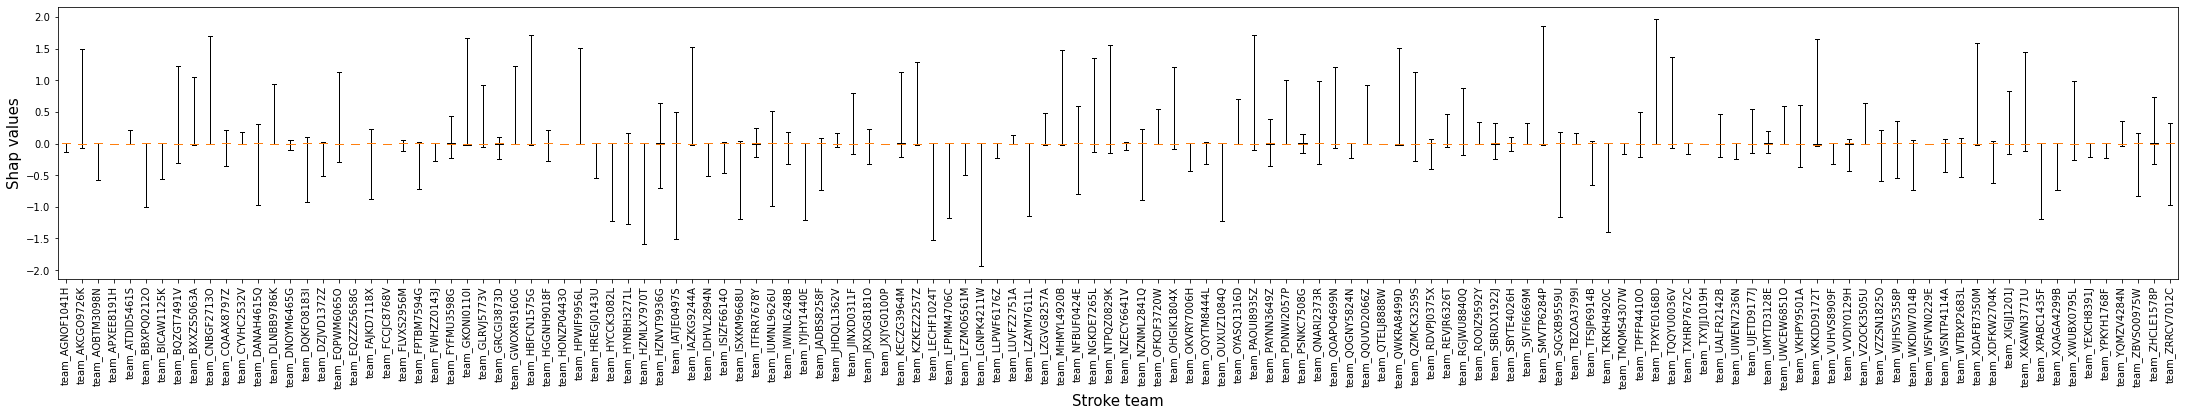

In [233]:
stroketeam_groups = []
for col in df_hosp_shap_values.columns[:-1]:#stroketeam_categories:
    stroketeam_groups.append(df_hosp_shap_values[col])

#plot boxplot
plt.figure(figsize=(38, 5))

plt.boxplot(stroketeam_groups,labels=df_hosp_shap_values.columns[:-1],whis=99999)

plt.ylabel('Shap values',size=15)
plt.xlabel('Stroke team',size=15)
plt.xticks(rotation=90)
plt.show()
#plt.savefig(path.format('boxplot.png'),dpi=100,bbox_inches='tight')

Shows the contribution from this hospital


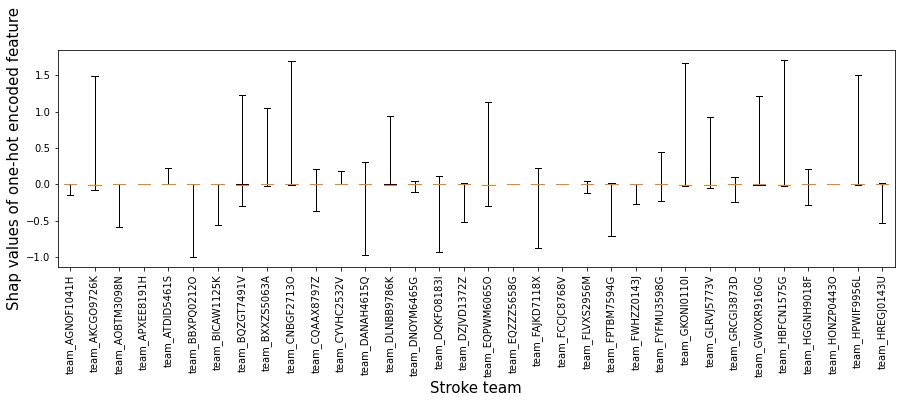

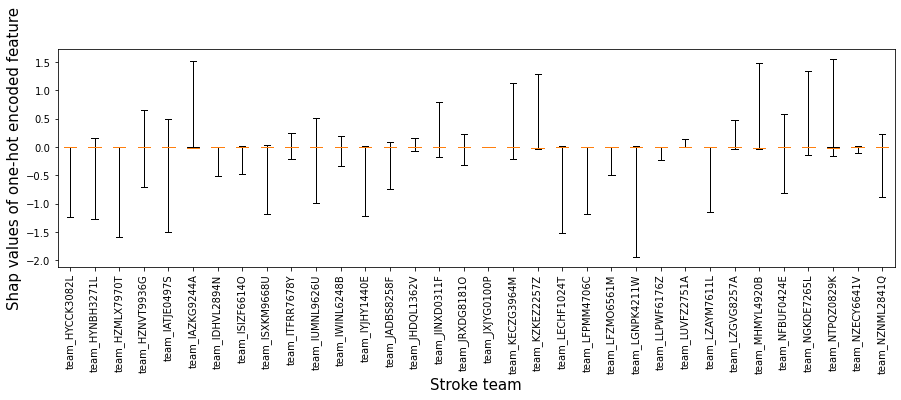

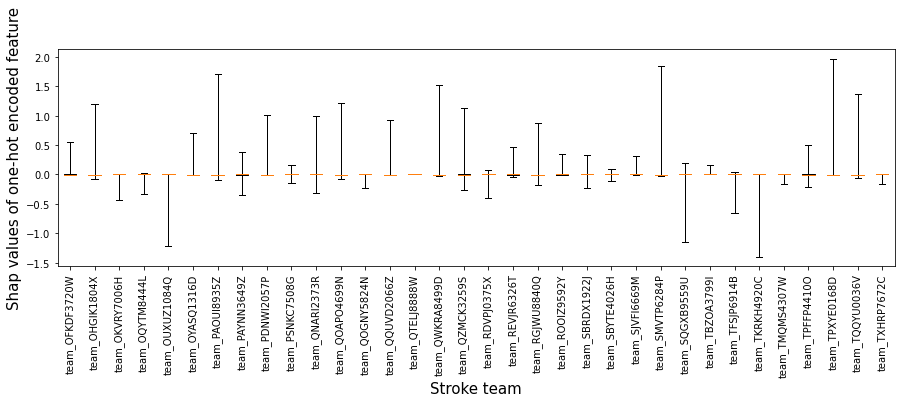

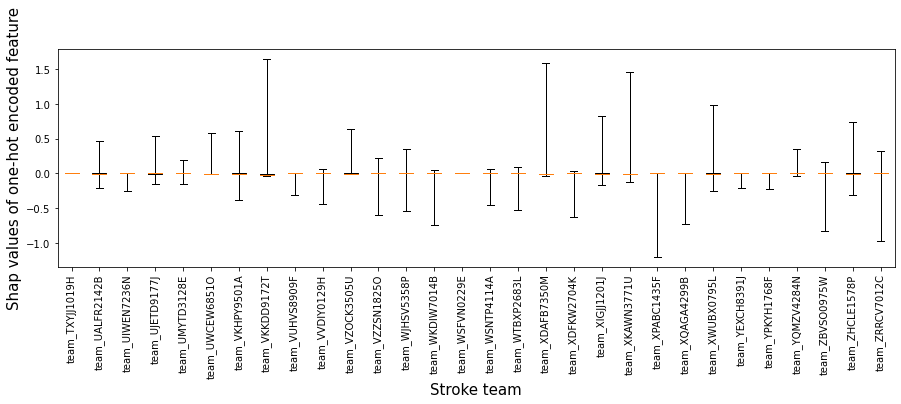

In [231]:
# Figure per 35 hosptials
stroketeam_groups = []
for col in df_hosp_shap_values.columns[:-1]:#stroketeam_categories:
    stroketeam_groups.append(df_hosp_shap_values[col])

print("Shows the contribution from this hospital")
# Create boxplots with 35 stroke teams in each
st = 0
ed = 34
inc = ed
max_size = len(stroketeam_groups)
for i in range(4):
    #plot boxplot
    plt.figure(figsize=(15, 4))
    plt.boxplot(stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=99999)
    plt.ylabel('Shap values of one-hot encoded feature',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

Edit data so only contains instances when go to hospital

In [234]:
# Add stroke team column to dataframe
df_hosp_shap_values["Stroke team"] = X_combined["Stroke team"].values

In [235]:
# Only include SHAP value for instances that attend stroke team
attend_stroketeam_groups = []
for col in df_hosp_shap_values.columns[:-1]:
    mask = df_hosp_shap_values['Stroke team'] == col[5:] #drop "team_"
    attend_stroketeam_groups.append(df_hosp_shap_values[col][mask])

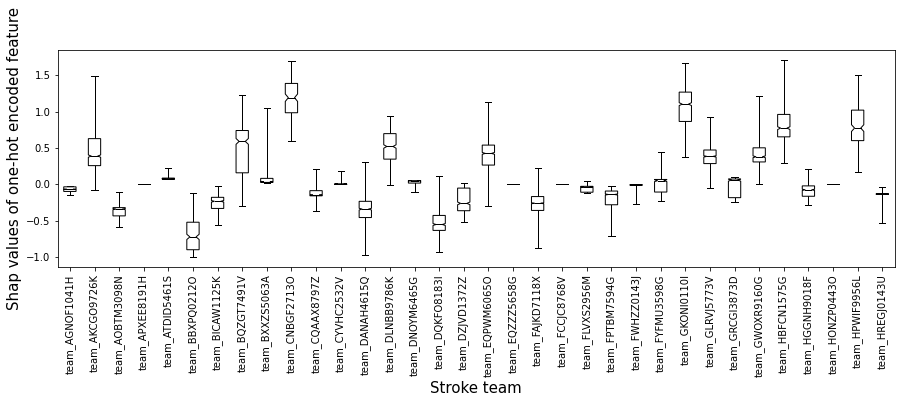

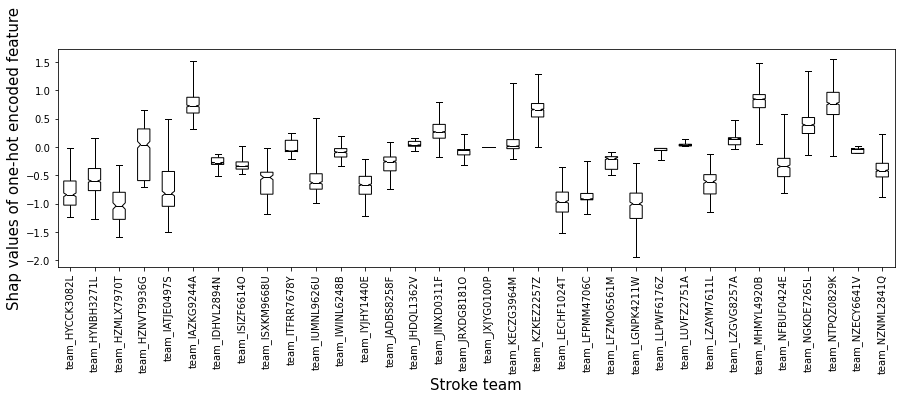

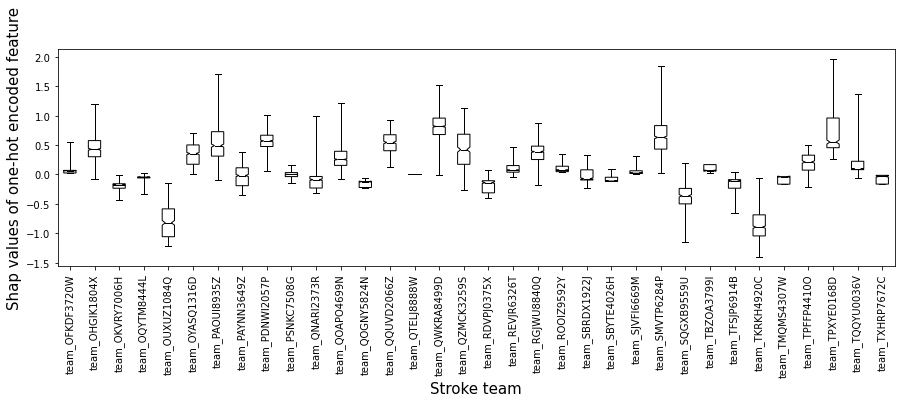

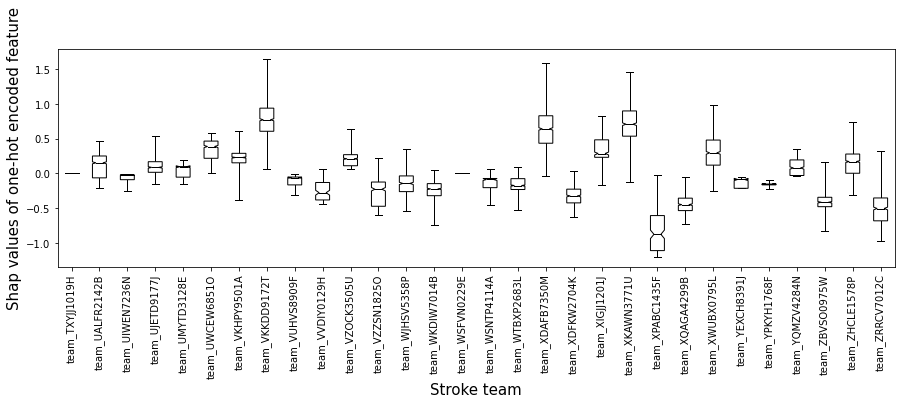

In [236]:
# Create boxplots with 35 stroke teams in each
st = 0
ed = 34
inc = ed
max_size = len(not_attend_stroketeam_groups)
for i in range(4):
    #plot boxplot
    plt.figure(figsize=(15, 4))
        
    #    print("Shows the contribution from this hospital when patients do attend this hosptial")
    c1 = "black"
    c2 = "black"
    c3 = "white"
    plt.boxplot(attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=99999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))

    plt.ylabel('Shap values of one-hot encoded feature',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

Edit data so only contains instances when not go to hospital

In [237]:
# Only include SHAP value for instances that do not attend stroke team
not_attend_stroketeam_groups = []
for col in df_hosp_shap_values.columns[:-1]:
    mask = df_hosp_shap_values['Stroke team'] != col[5:] #drop "team_"
    not_attend_stroketeam_groups.append(df_hosp_shap_values[col][mask])

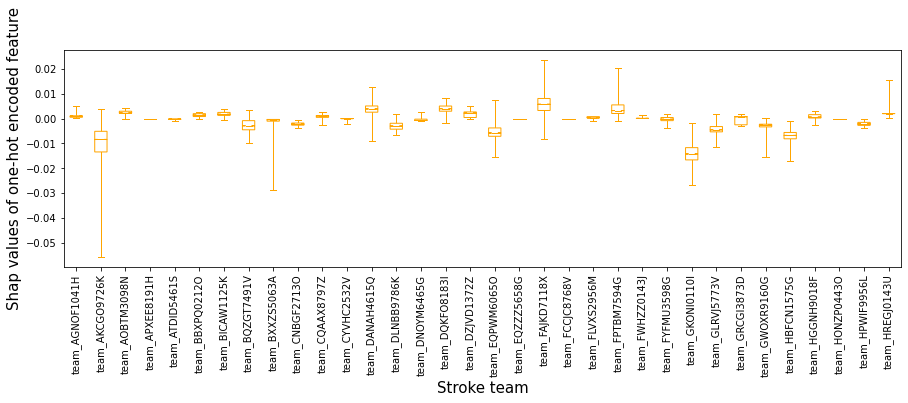

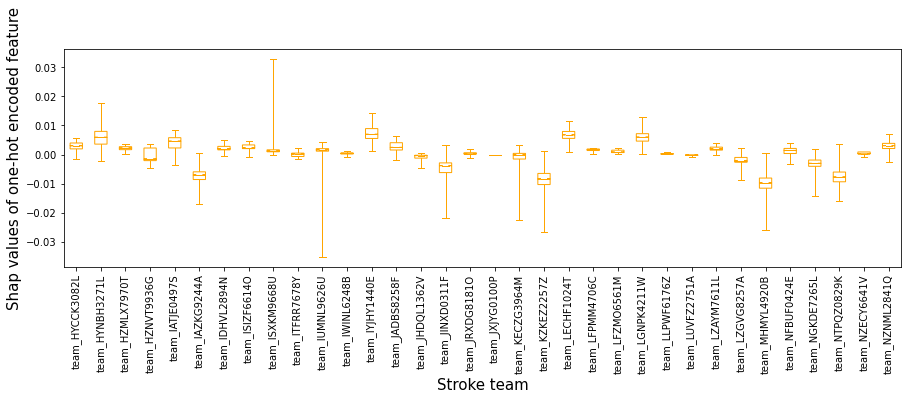

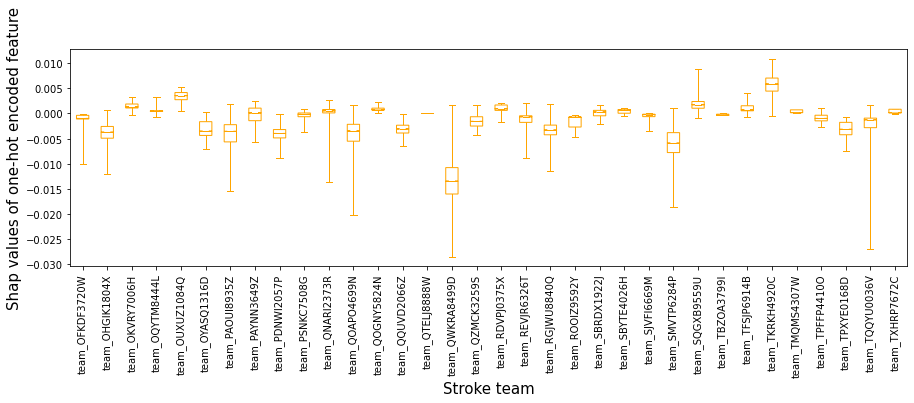

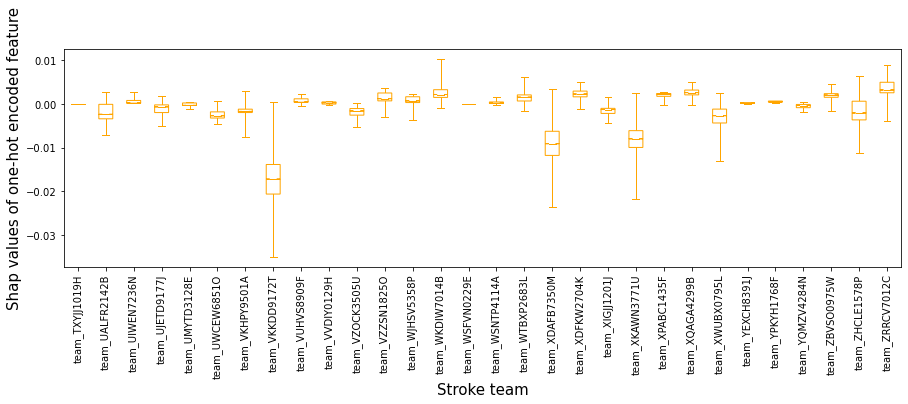

In [238]:
# Create boxplots with 35 stroke teams in each
st = 0
ed = 34
inc = ed
max_size = len(not_attend_stroketeam_groups)
for i in range(4):
    #plot boxplot
    plt.figure(figsize=(15, 4))

    #    print("Shows the contribution from this hospital when patients do not attend this hosptial")
    c1 = "orange"
    c2 = "orange"
    c3 = "white"
    plt.boxplot(not_attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=99999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))
        
    plt.ylabel('Shap values of one-hot encoded feature',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

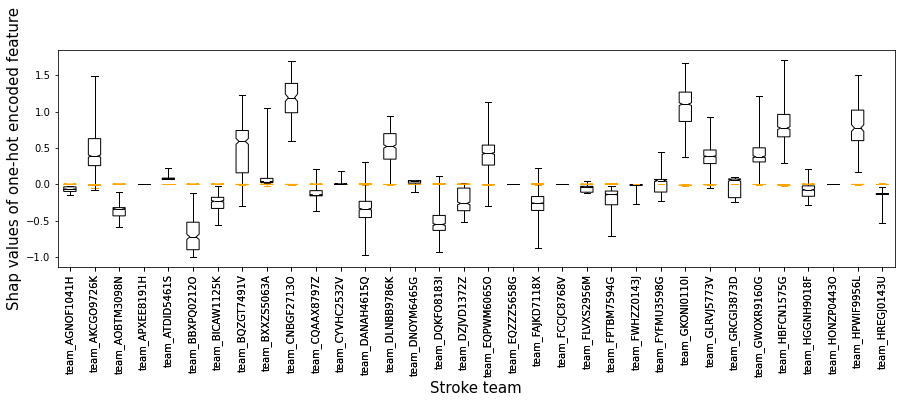

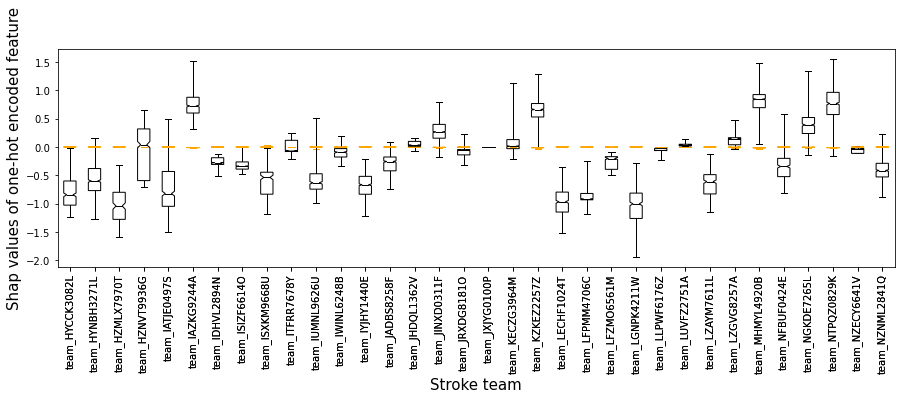

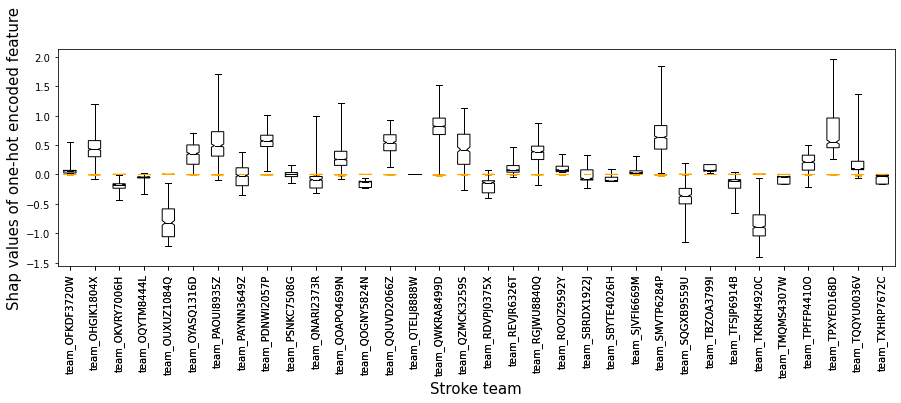

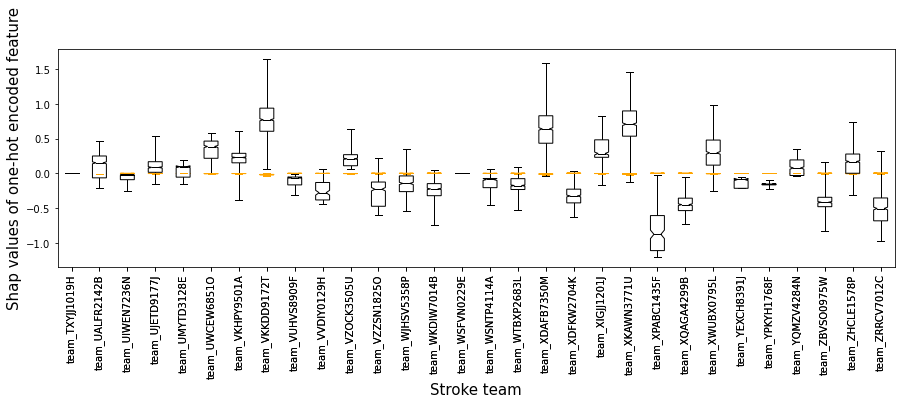

In [239]:
# 2 box plots on 1 plot (spread of SHAP when instance attend, and not attend, hospital)

# Create boxplots with 35 stroke teams in each
st = 0
ed = 34
inc = ed
max_size = len(not_attend_stroketeam_groups)
for i in range(4):
    #plot boxplot
    plt.figure(figsize=(15, 4))

    #    print("Shows the contribution from this hospital when patients do not attend this hosptial")
    c1 = "orange"
    c2 = "orange"
    c3 = "white"
    plt.boxplot(not_attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=99999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))
        
    #    print("Shows the contribution from this hospital when patients do attend this hosptial")
    c1 = "black"
    c2 = "black"
    c3 = "white"
    plt.boxplot(attend_stroketeam_groups[st:ed],
                labels=df_hosp_shap_values.columns[st:ed],
                whis=99999,patch_artist=True, notch=True,
                boxprops=dict(facecolor=c3, color=c1),
                capprops=dict(color=c1),
                whiskerprops=dict(color=c1),
                flierprops=dict(color=c1, markeredgecolor=c1),
                medianprops=dict(color=c2))

    plt.ylabel('Shap values of one-hot encoded feature',size=15)
    plt.xlabel('Stroke team',size=15)
    plt.xticks(rotation=90)
    plt.show()
    st = min(st+inc,max_size)
    ed = min(ed+inc,max_size)

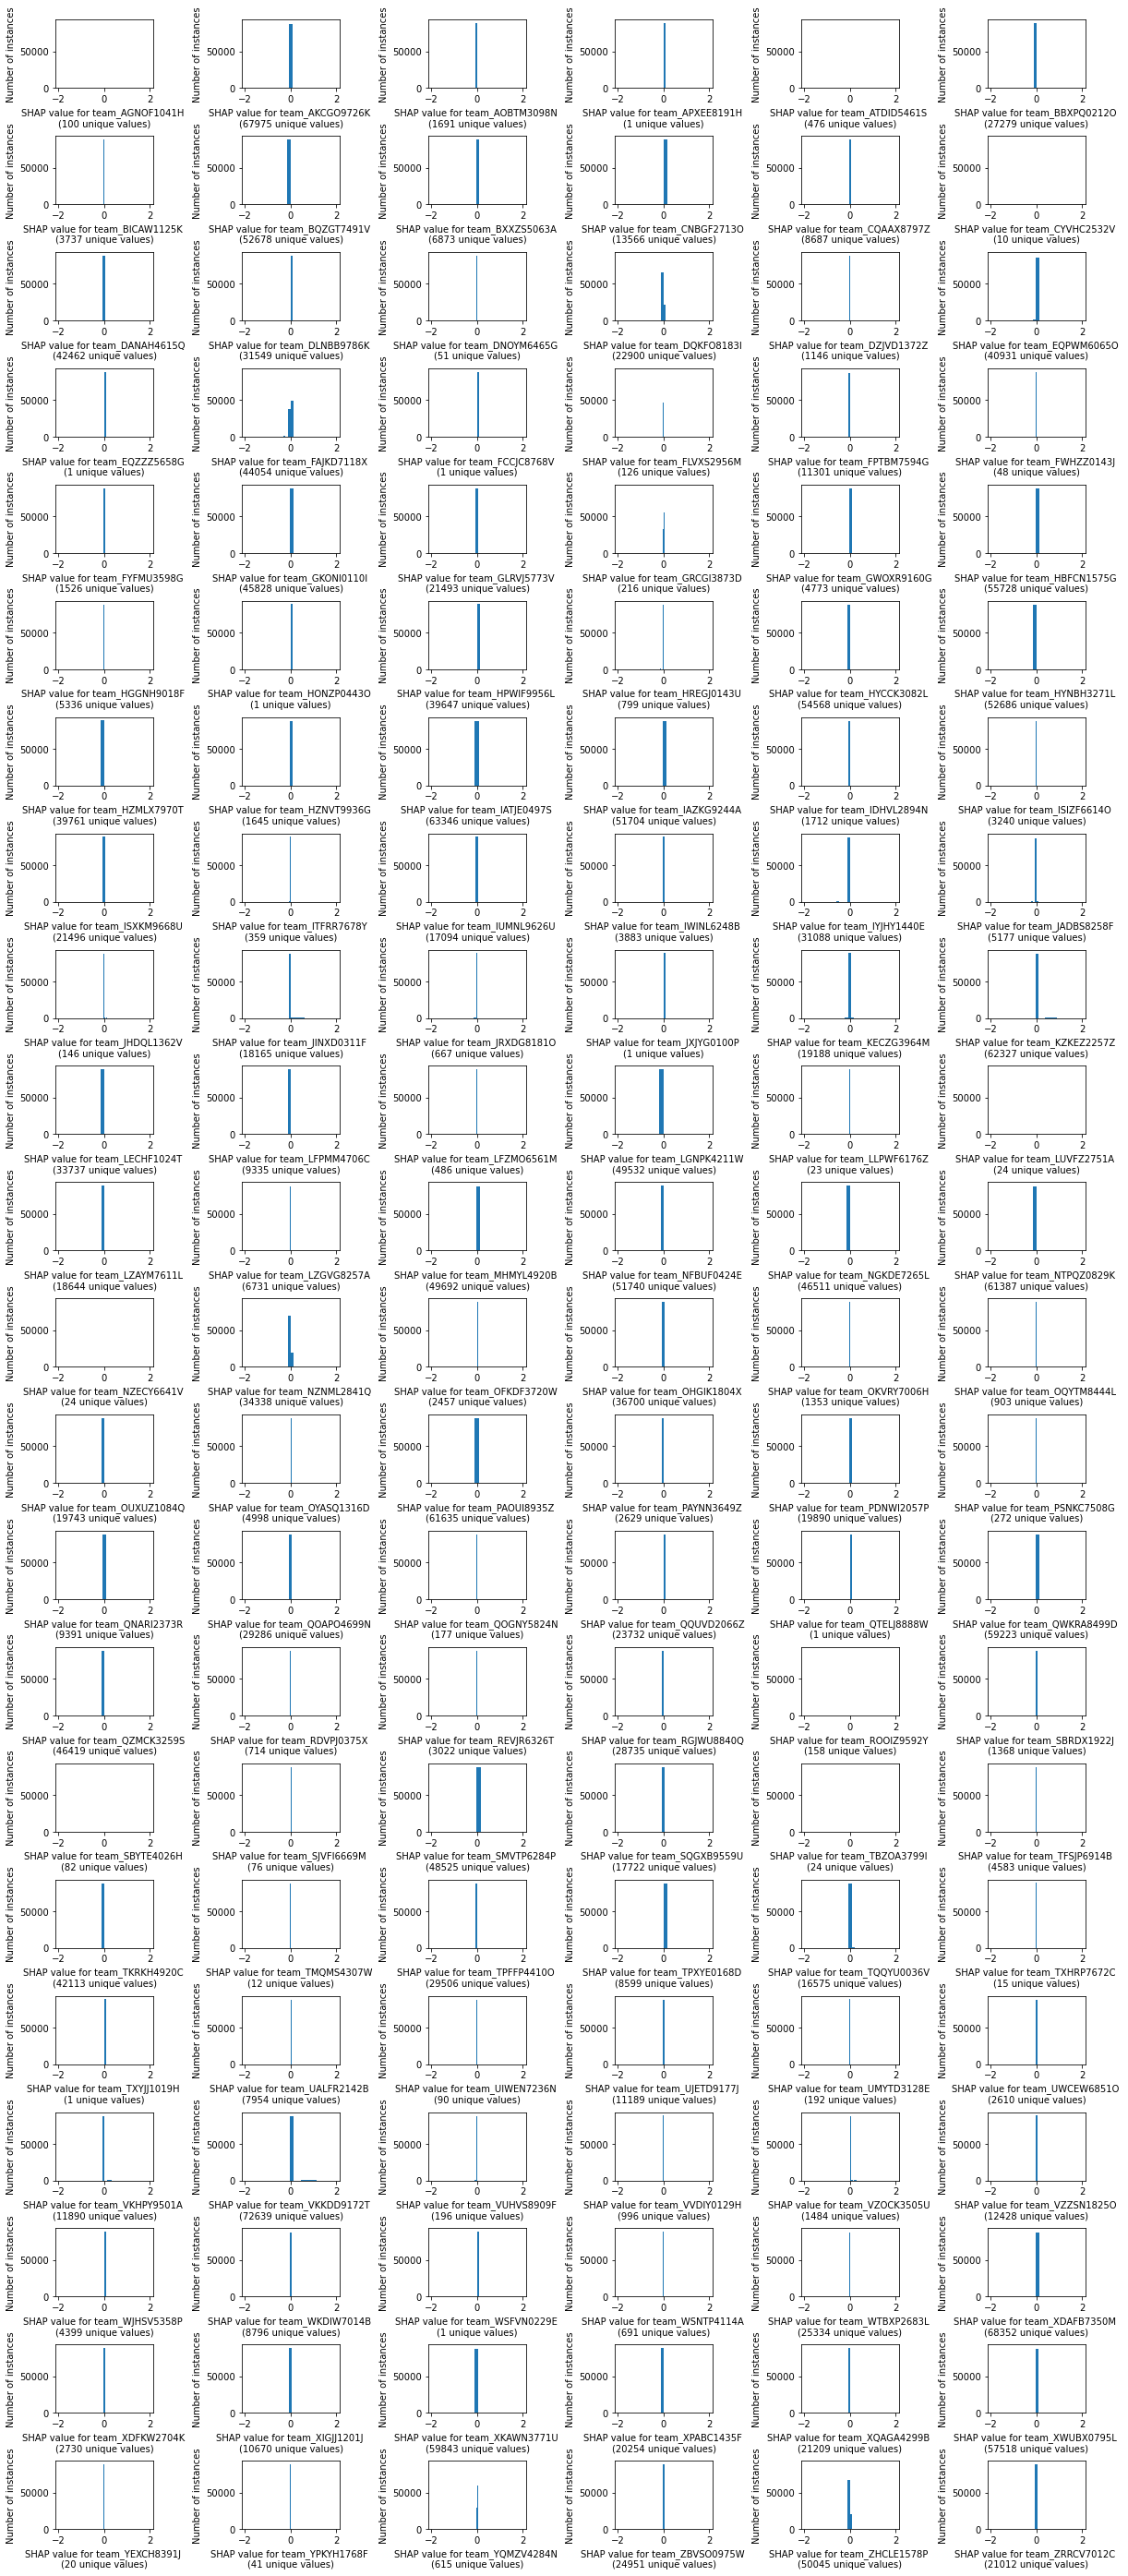

In [254]:
# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
x_min = 99
x_max = -99
fig, axes = plt.subplots(1)
for col in hospital_columns:
#    df_hosp_shap_values[col].plot.hist(bins=100, ax=axes[count])
    axes.hist(df_hosp_shap_values[col])
    ylims = axes.get_ylim()
    # Store if greater than found so far
    y_max = max(y_max, ylims[1])
    xlims = axes.get_xlim()
    # Store if greater than found so far
    x_min = min(x_min, xlims[0])
    x_max = max(x_max, xlims[1])
# Don't display plot
plt.close(fig)

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for col in hospital_columns:
    n_unique = df_hosp_shap_values[col].nunique()
    ax=axes[count]
    ax.hist(df_hosp_shap_values[col])# including bins=100 made it worse
    ax.set_xlabel(f"SHAP value for {col} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances")
    ax.set_ylim(0, y_max)
    ax.set_xlim(x_min, x_max)
    count += 1
        
fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

Why empty histograms?
Is it because the bar hieght is dependant on the width and so changing the xaxis range interferes with the bar visualisation?

Repeat as individual plots to see if this helps to work this out.

team_AGNOF1041H. Number of unique values: 100


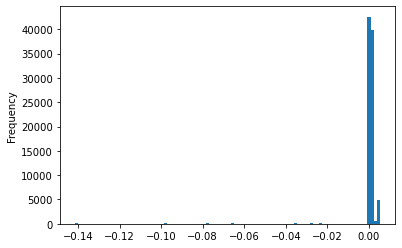

team_AKCGO9726K. Number of unique values: 67975


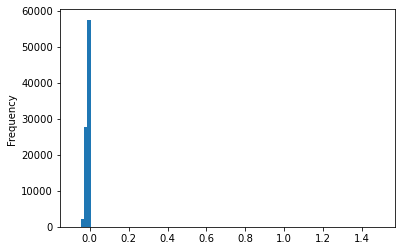

team_AOBTM3098N. Number of unique values: 1691


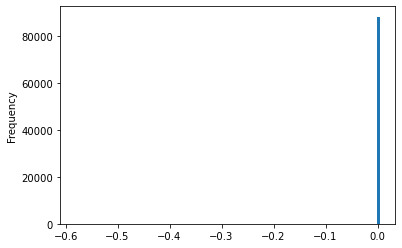

team_APXEE8191H. Number of unique values: 1


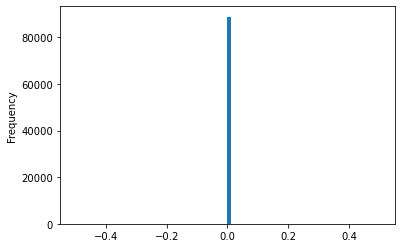

team_ATDID5461S. Number of unique values: 476


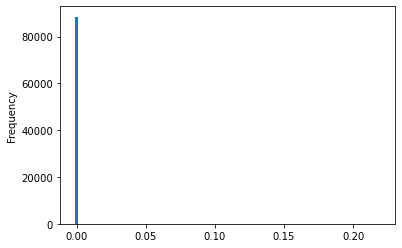

team_BBXPQ0212O. Number of unique values: 27279


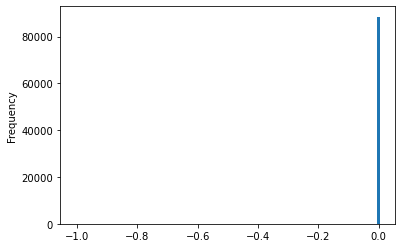

team_BICAW1125K. Number of unique values: 3737


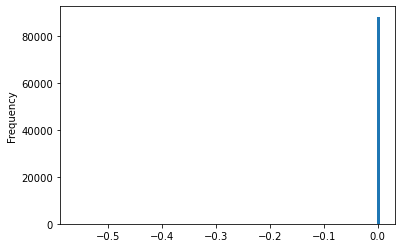

team_BQZGT7491V. Number of unique values: 52678


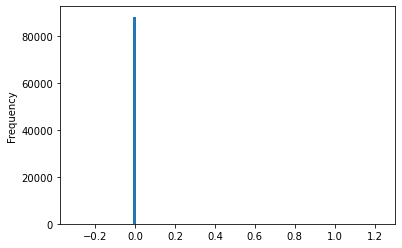

team_BXXZS5063A. Number of unique values: 6873


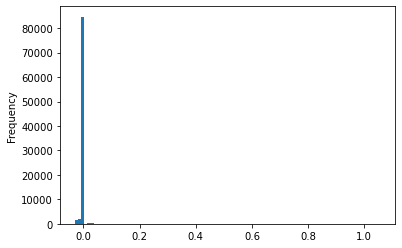

team_CNBGF2713O. Number of unique values: 13566


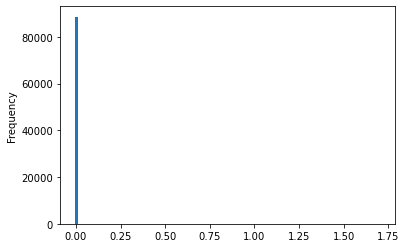

team_CQAAX8797Z. Number of unique values: 8687


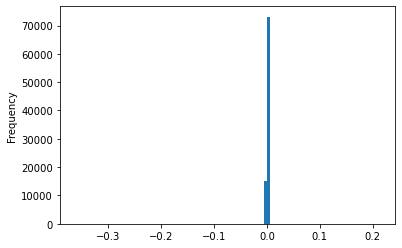

team_CYVHC2532V. Number of unique values: 10


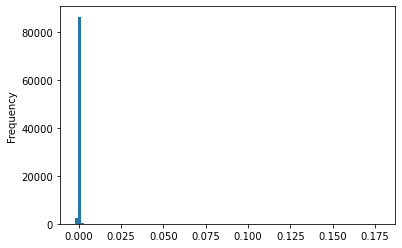

team_DANAH4615Q. Number of unique values: 42462


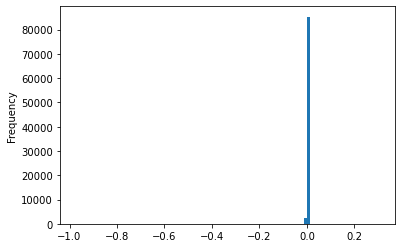

team_DLNBB9786K. Number of unique values: 31549


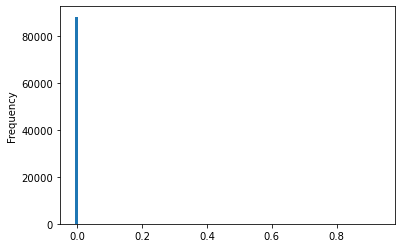

team_DNOYM6465G. Number of unique values: 51


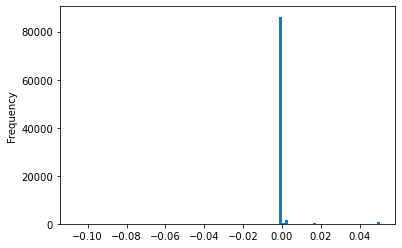

team_DQKFO8183I. Number of unique values: 22900


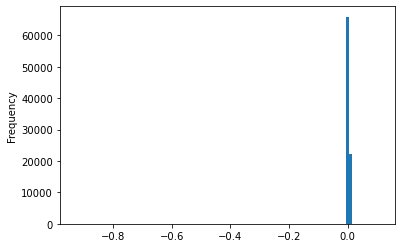

team_DZJVD1372Z. Number of unique values: 1146


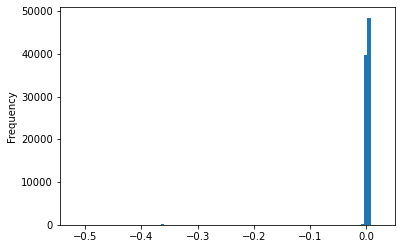

team_EQPWM6065O. Number of unique values: 40931


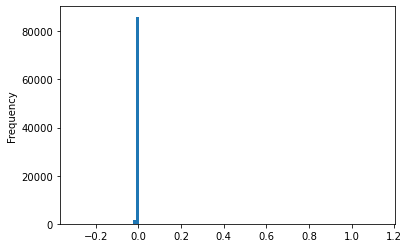

team_EQZZZ5658G. Number of unique values: 1


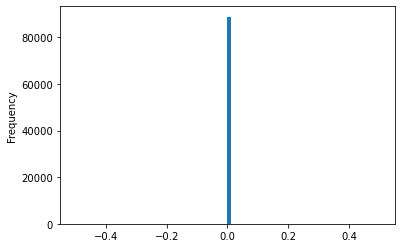

team_FAJKD7118X. Number of unique values: 44054


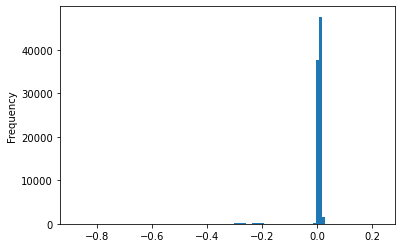

team_FCCJC8768V. Number of unique values: 1


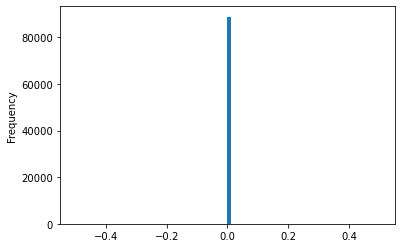

team_FLVXS2956M. Number of unique values: 126


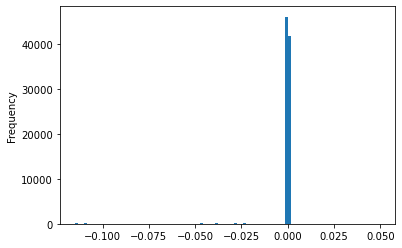

team_FPTBM7594G. Number of unique values: 11301


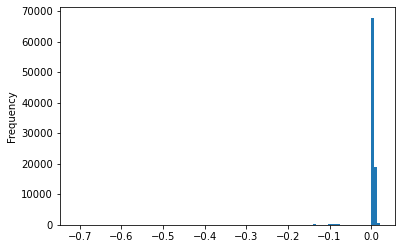

team_FWHZZ0143J. Number of unique values: 48


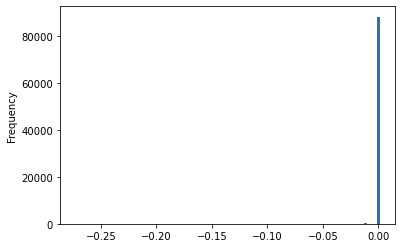

team_FYFMU3598G. Number of unique values: 1526


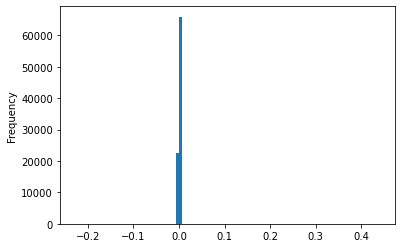

team_GKONI0110I. Number of unique values: 45828


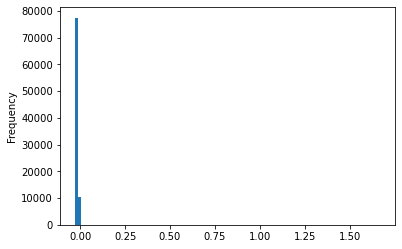

team_GLRVJ5773V. Number of unique values: 21493


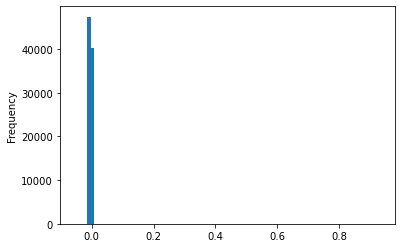

team_GRCGI3873D. Number of unique values: 216


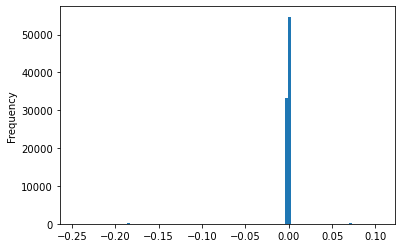

team_GWOXR9160G. Number of unique values: 4773


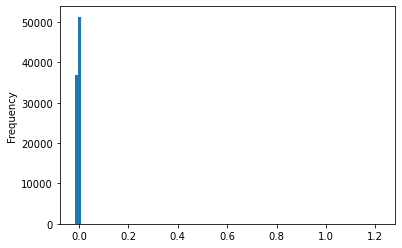

team_HBFCN1575G. Number of unique values: 55728


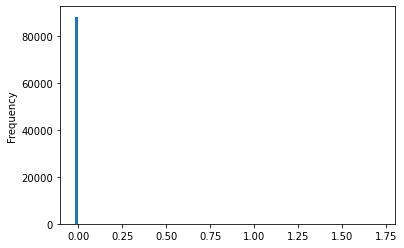

team_HGGNH9018F. Number of unique values: 5336


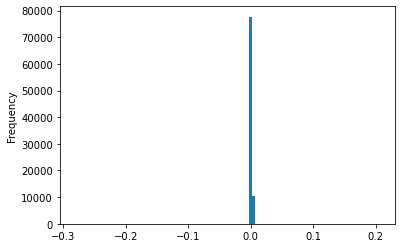

team_HONZP0443O. Number of unique values: 1


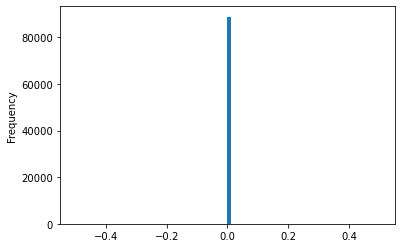

team_HPWIF9956L. Number of unique values: 39647


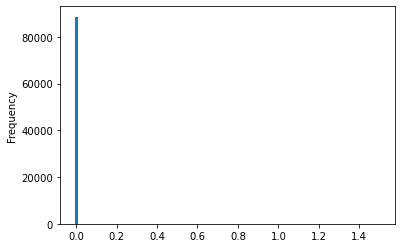

team_HREGJ0143U. Number of unique values: 799


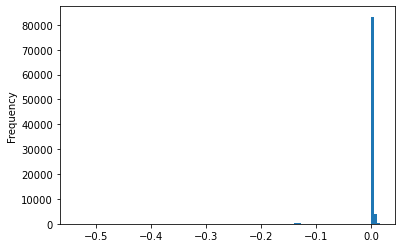

team_HYCCK3082L. Number of unique values: 54568


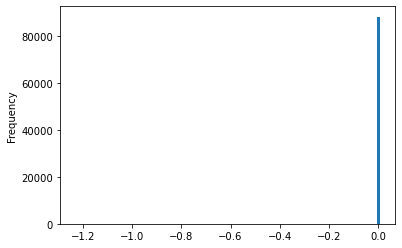

team_HYNBH3271L. Number of unique values: 52686


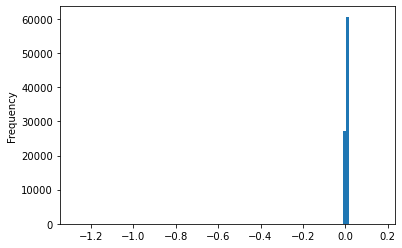

team_HZMLX7970T. Number of unique values: 39761


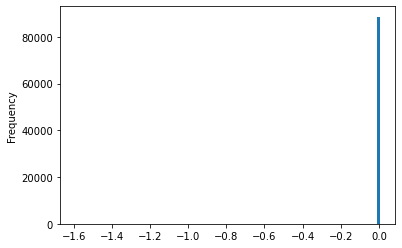

team_HZNVT9936G. Number of unique values: 1645


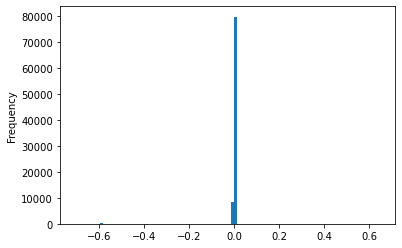

team_IATJE0497S. Number of unique values: 63346


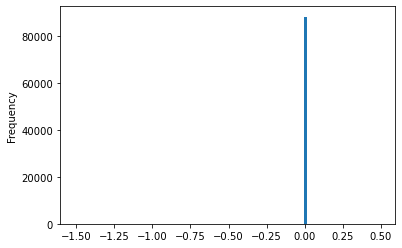

team_IAZKG9244A. Number of unique values: 51704


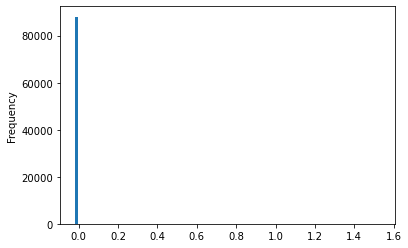

team_IDHVL2894N. Number of unique values: 1712


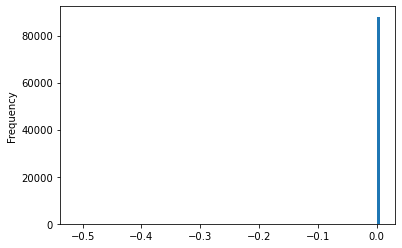

team_ISIZF6614O. Number of unique values: 3240


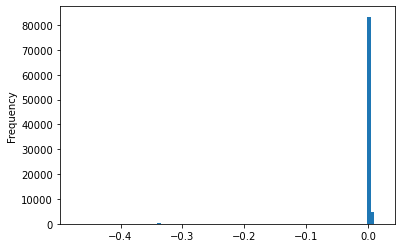

team_ISXKM9668U. Number of unique values: 21496


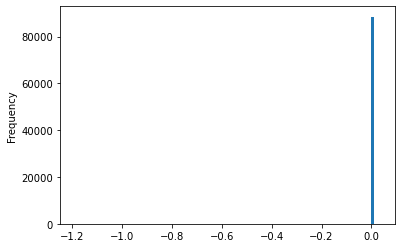

team_ITFRR7678Y. Number of unique values: 359


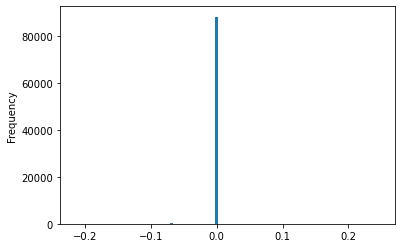

team_IUMNL9626U. Number of unique values: 17094


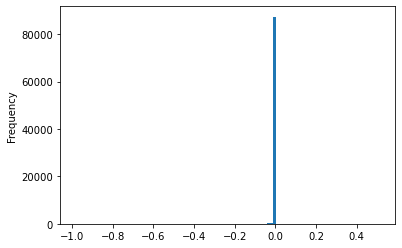

team_IWINL6248B. Number of unique values: 3883


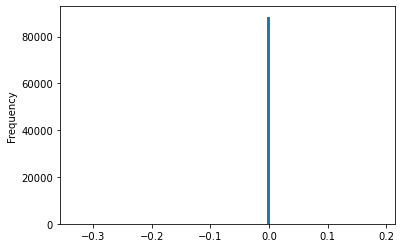

team_IYJHY1440E. Number of unique values: 31088


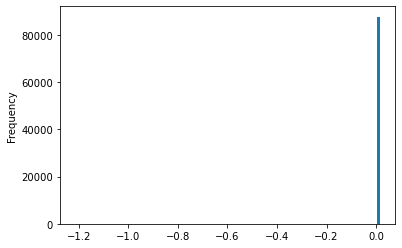

team_JADBS8258F. Number of unique values: 5177


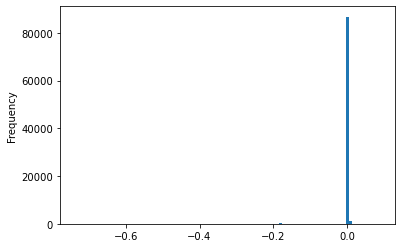

team_JHDQL1362V. Number of unique values: 146


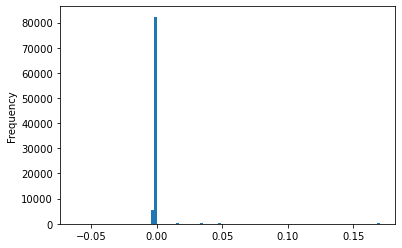

team_JINXD0311F. Number of unique values: 18165


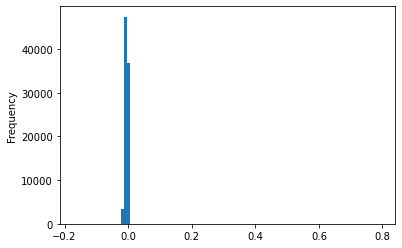

team_JRXDG8181O. Number of unique values: 667


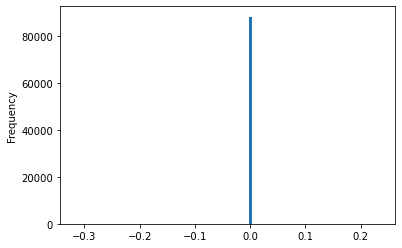

team_JXJYG0100P. Number of unique values: 1


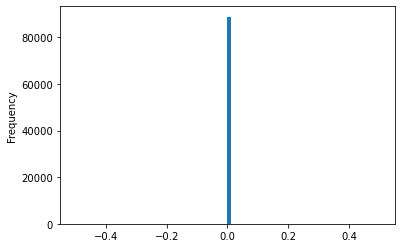

team_KECZG3964M. Number of unique values: 19188


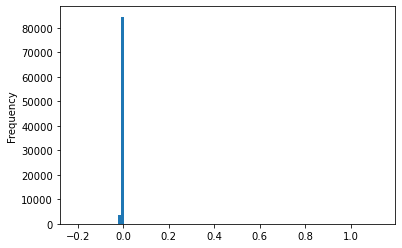

team_KZKEZ2257Z. Number of unique values: 62327


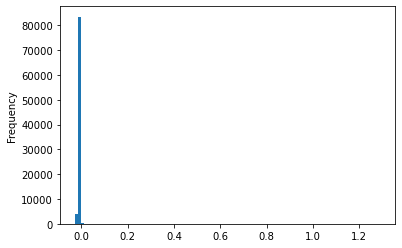

team_LECHF1024T. Number of unique values: 33737


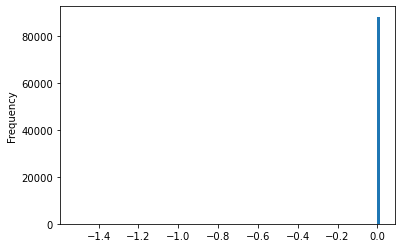

team_LFPMM4706C. Number of unique values: 9335


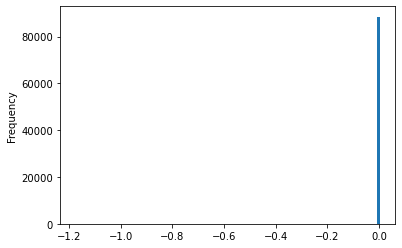

team_LFZMO6561M. Number of unique values: 486


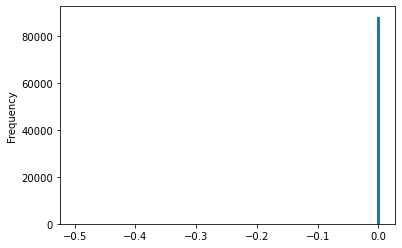

team_LGNPK4211W. Number of unique values: 49532


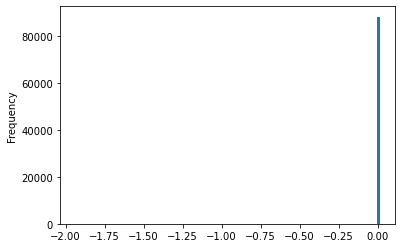

team_LLPWF6176Z. Number of unique values: 23


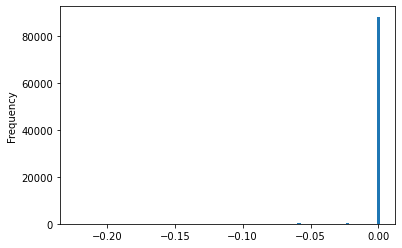

team_LUVFZ2751A. Number of unique values: 24


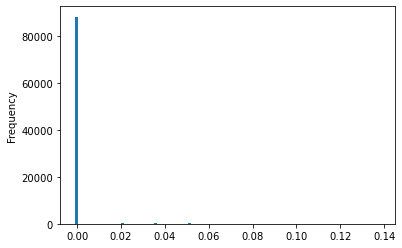

team_LZAYM7611L. Number of unique values: 18644


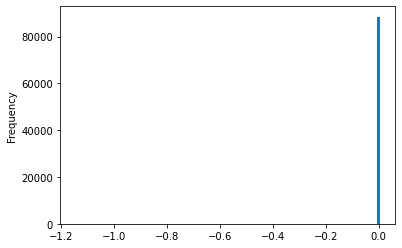

team_LZGVG8257A. Number of unique values: 6731


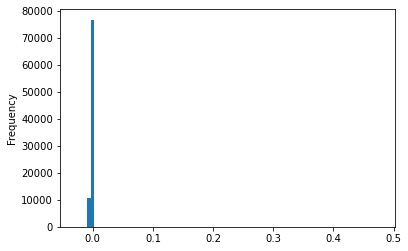

team_MHMYL4920B. Number of unique values: 49692


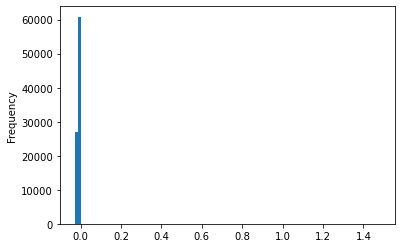

team_NFBUF0424E. Number of unique values: 51740


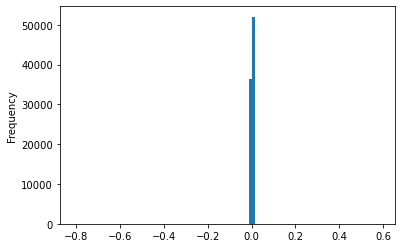

team_NGKDE7265L. Number of unique values: 46511


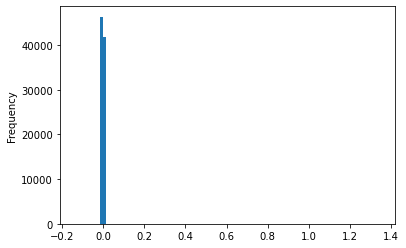

team_NTPQZ0829K. Number of unique values: 61387


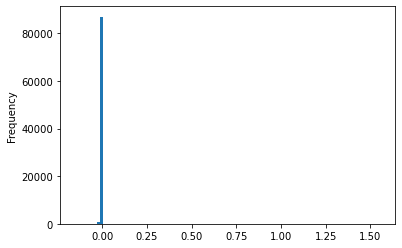

team_NZECY6641V. Number of unique values: 24


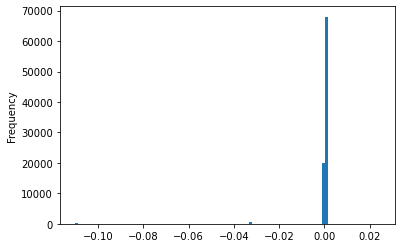

team_NZNML2841Q. Number of unique values: 34338


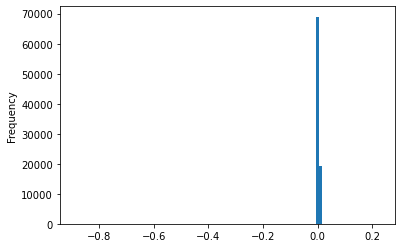

team_OFKDF3720W. Number of unique values: 2457


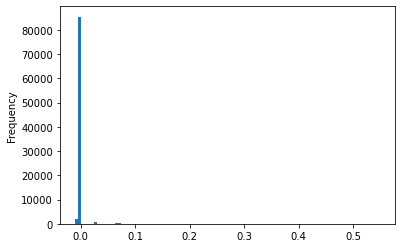

team_OHGIK1804X. Number of unique values: 36700


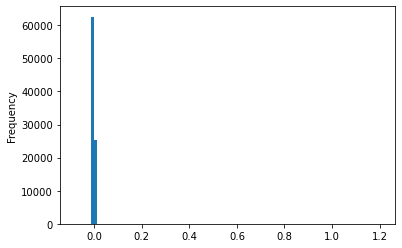

team_OKVRY7006H. Number of unique values: 1353


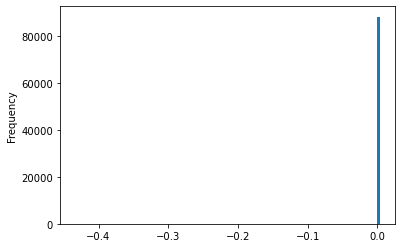

team_OQYTM8444L. Number of unique values: 903


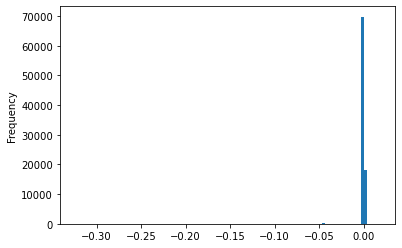

team_OUXUZ1084Q. Number of unique values: 19743


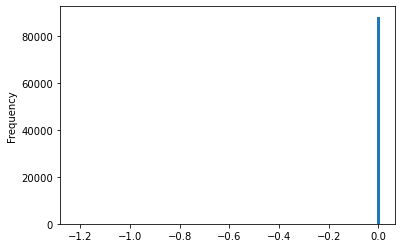

team_OYASQ1316D. Number of unique values: 4998


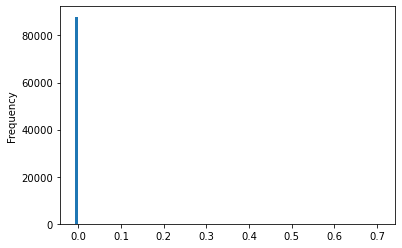

team_PAOUI8935Z. Number of unique values: 61635


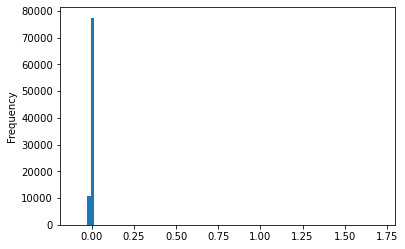

team_PAYNN3649Z. Number of unique values: 2629


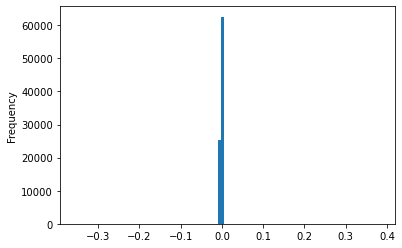

team_PDNWI2057P. Number of unique values: 19890


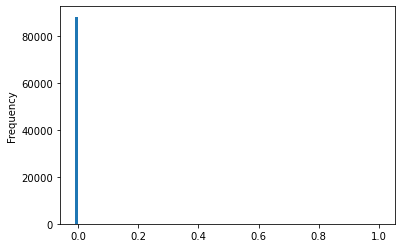

team_PSNKC7508G. Number of unique values: 272


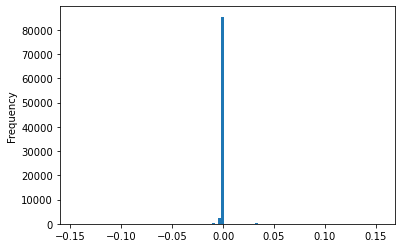

team_QNARI2373R. Number of unique values: 9391


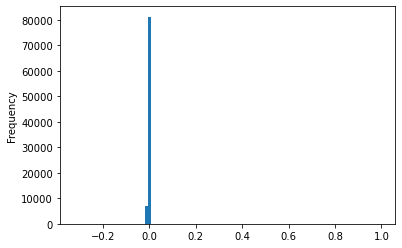

team_QOAPO4699N. Number of unique values: 29286


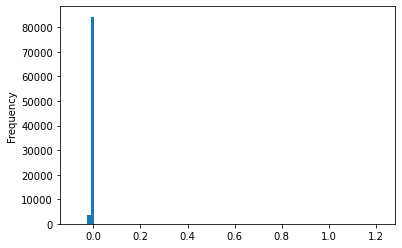

team_QOGNY5824N. Number of unique values: 177


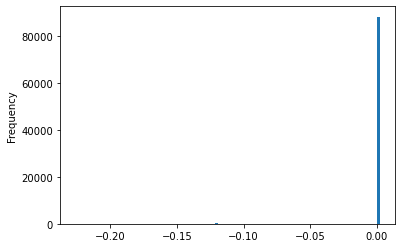

team_QQUVD2066Z. Number of unique values: 23732


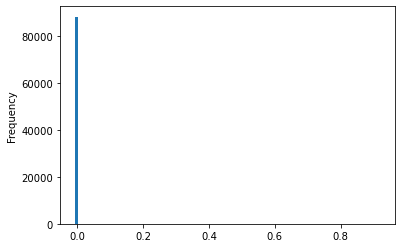

team_QTELJ8888W. Number of unique values: 1


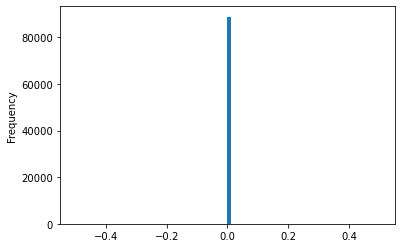

team_QWKRA8499D. Number of unique values: 59223


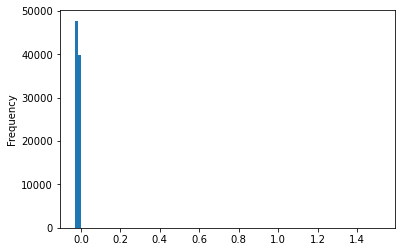

team_QZMCK3259S. Number of unique values: 46419


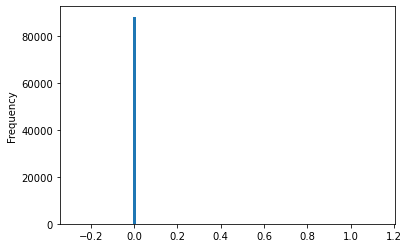

team_RDVPJ0375X. Number of unique values: 714


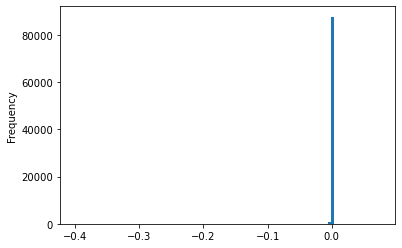

team_REVJR6326T. Number of unique values: 3022


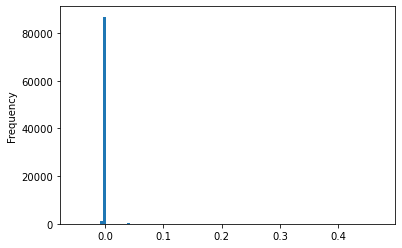

team_RGJWU8840Q. Number of unique values: 28735


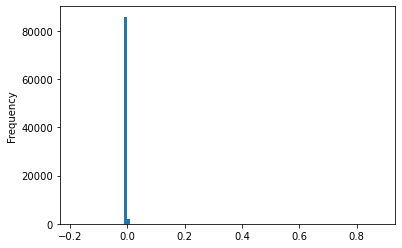

team_ROOIZ9592Y. Number of unique values: 158


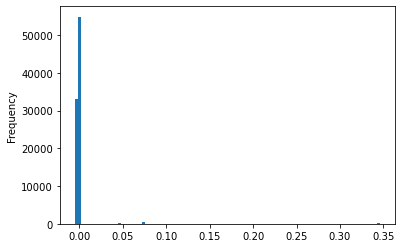

team_SBRDX1922J. Number of unique values: 1368


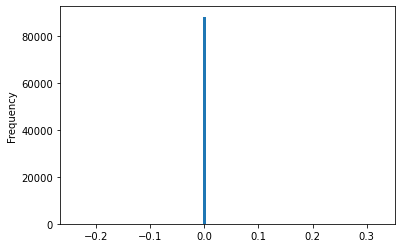

team_SBYTE4026H. Number of unique values: 82


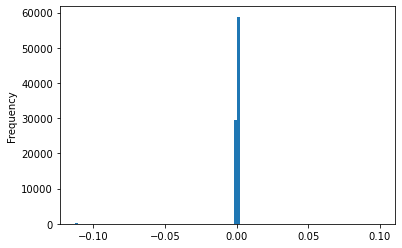

team_SJVFI6669M. Number of unique values: 76


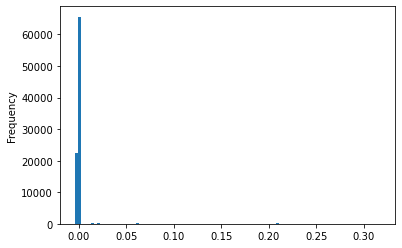

team_SMVTP6284P. Number of unique values: 48525


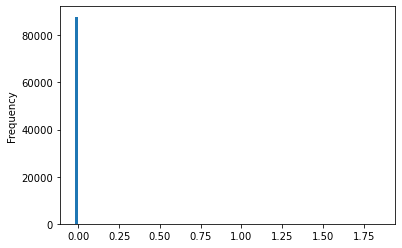

team_SQGXB9559U. Number of unique values: 17722


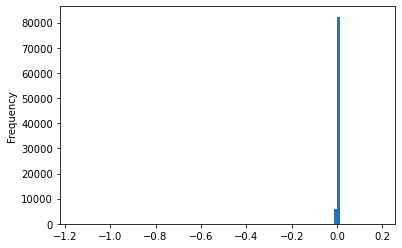

team_TBZOA3799I. Number of unique values: 24


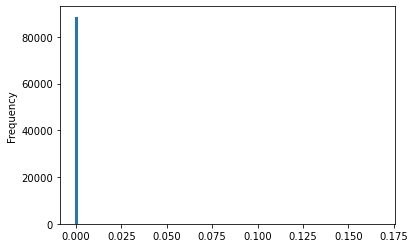

team_TFSJP6914B. Number of unique values: 4583


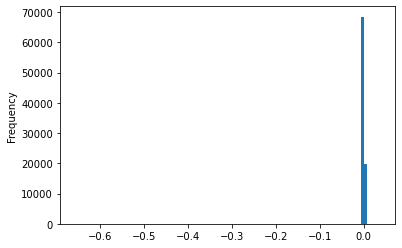

team_TKRKH4920C. Number of unique values: 42113


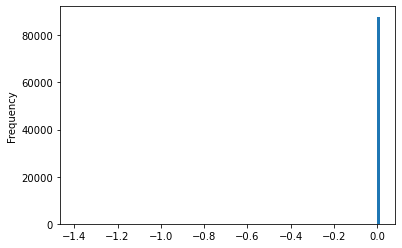

team_TMQMS4307W. Number of unique values: 12


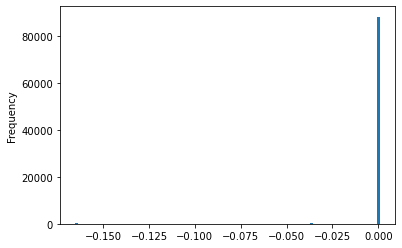

team_TPFFP4410O. Number of unique values: 29506


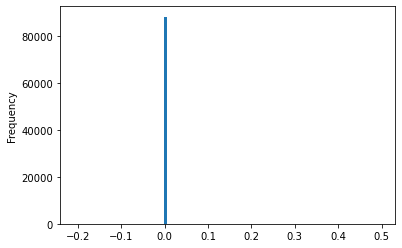

team_TPXYE0168D. Number of unique values: 8599


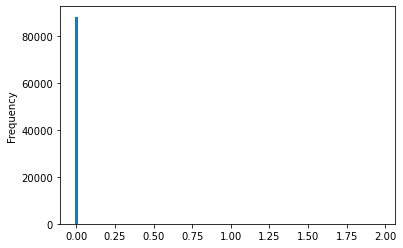

team_TQQYU0036V. Number of unique values: 16575


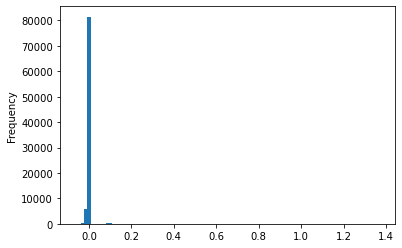

team_TXHRP7672C. Number of unique values: 15


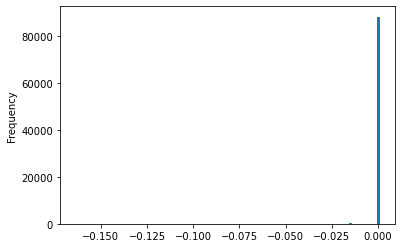

team_TXYJJ1019H. Number of unique values: 1


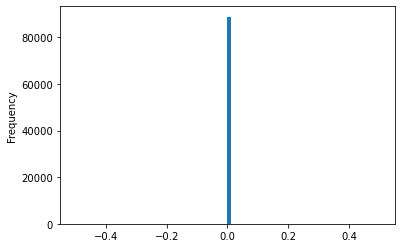

team_UALFR2142B. Number of unique values: 7954


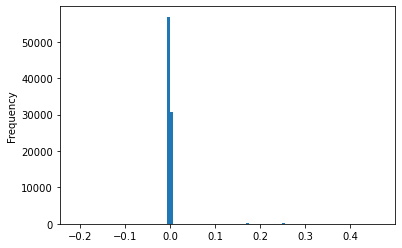

team_UIWEN7236N. Number of unique values: 90


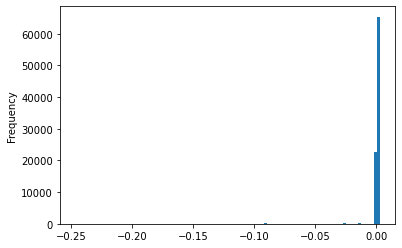

team_UJETD9177J. Number of unique values: 11189


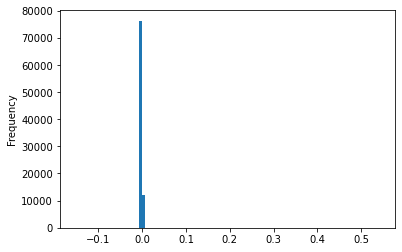

team_UMYTD3128E. Number of unique values: 192


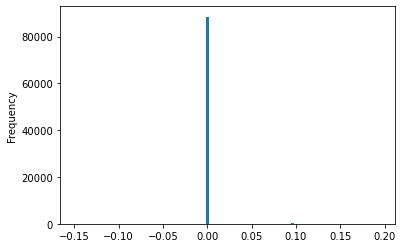

team_UWCEW6851O. Number of unique values: 2610


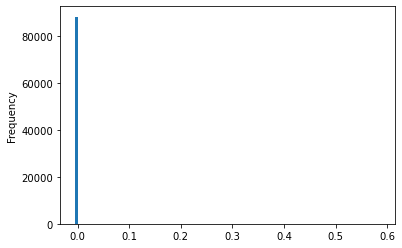

team_VKHPY9501A. Number of unique values: 11890


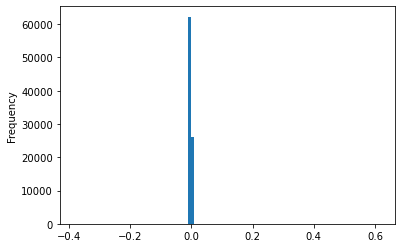

team_VKKDD9172T. Number of unique values: 72639


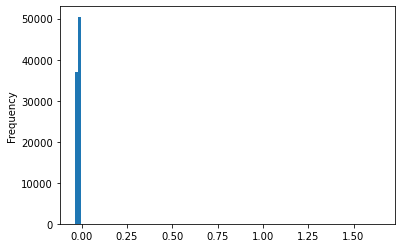

team_VUHVS8909F. Number of unique values: 196


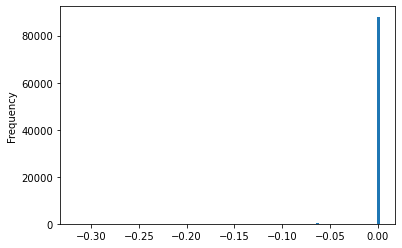

team_VVDIY0129H. Number of unique values: 996


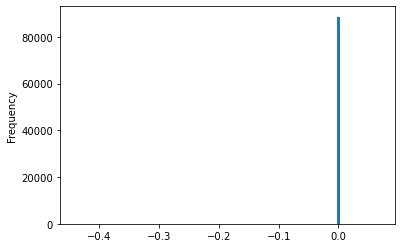

team_VZOCK3505U. Number of unique values: 1484


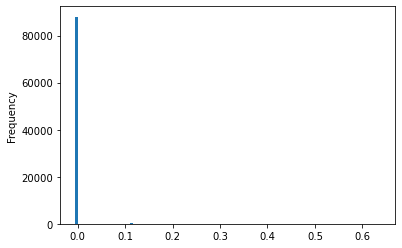

team_VZZSN1825O. Number of unique values: 12428


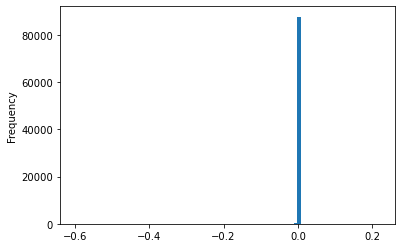

team_WJHSV5358P. Number of unique values: 4399


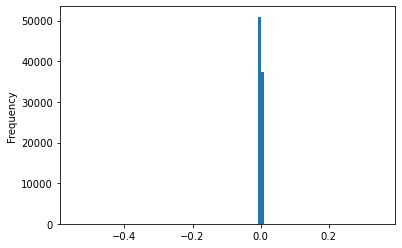

team_WKDIW7014B. Number of unique values: 8796


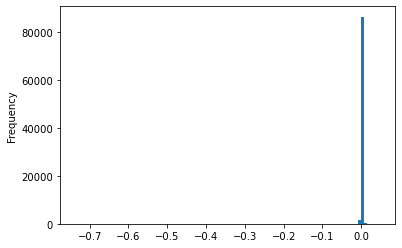

team_WSFVN0229E. Number of unique values: 1


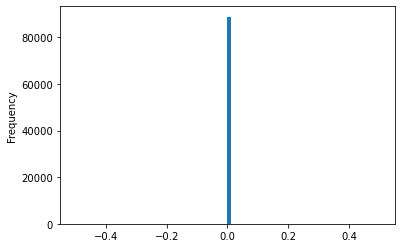

team_WSNTP4114A. Number of unique values: 691


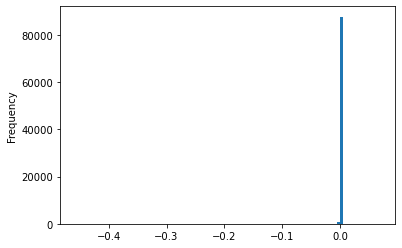

team_WTBXP2683L. Number of unique values: 25334


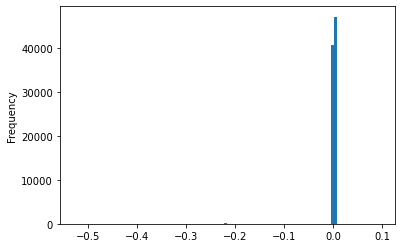

team_XDAFB7350M. Number of unique values: 68352


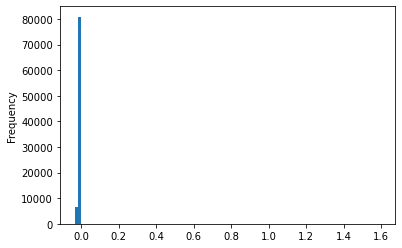

team_XDFKW2704K. Number of unique values: 2730


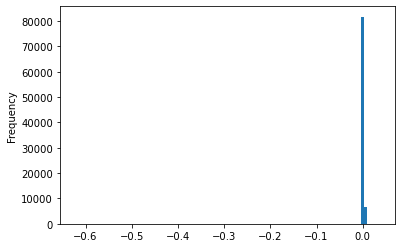

team_XIGJJ1201J. Number of unique values: 10670


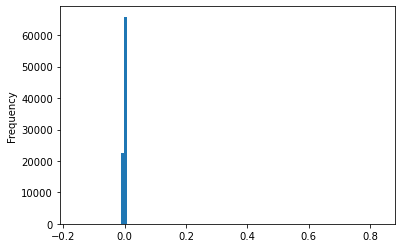

team_XKAWN3771U. Number of unique values: 59843


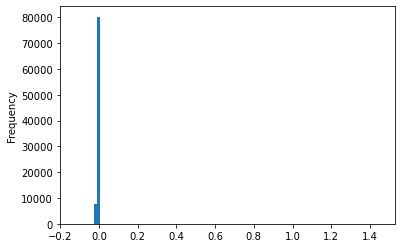

team_XPABC1435F. Number of unique values: 20254


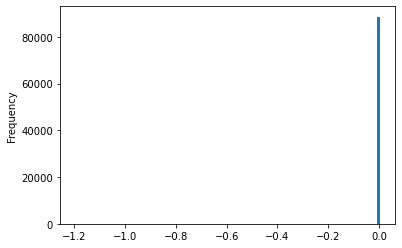

team_XQAGA4299B. Number of unique values: 21209


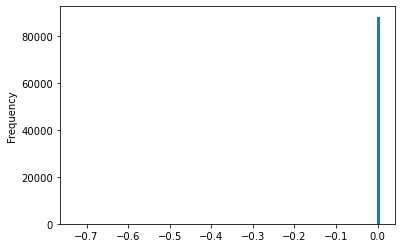

team_XWUBX0795L. Number of unique values: 57518


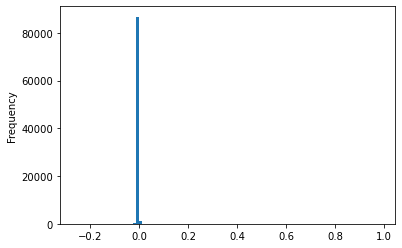

team_YEXCH8391J. Number of unique values: 20


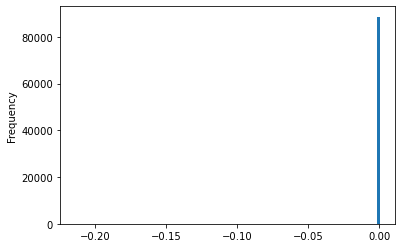

team_YPKYH1768F. Number of unique values: 41


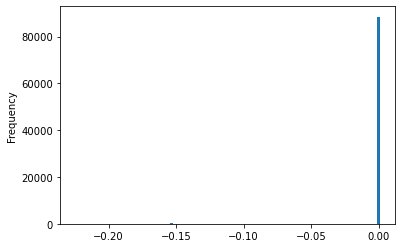

team_YQMZV4284N. Number of unique values: 615


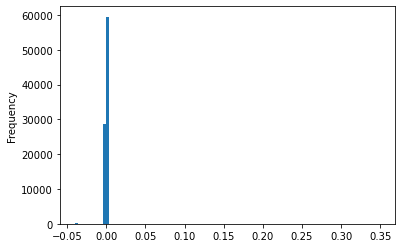

team_ZBVSO0975W. Number of unique values: 24951


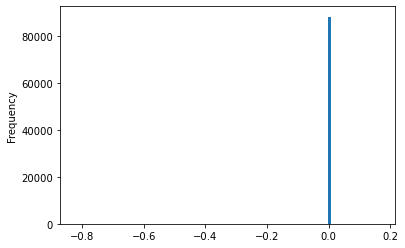

team_ZHCLE1578P. Number of unique values: 50045


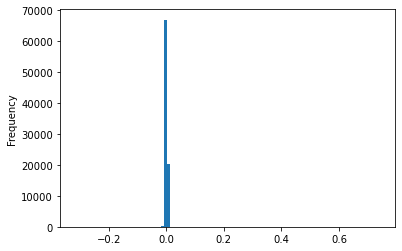

team_ZRRCV7012C. Number of unique values: 21012


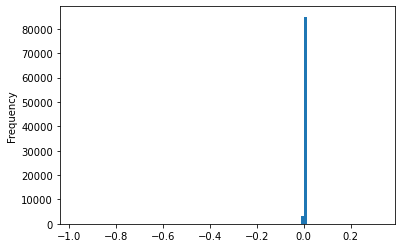

In [37]:
for col in hospital_columns:
    ax = df_hosp_shap_values[col].plot.hist(bins=100);
    print(f"{col}. Number of unique values: {df_hosp_shap_values[col].nunique()}")
    plt.show()

Look at histogram for first hospital, using two different histogram syntax (both look the same)

Number of unique values for team_AGNOF1041H: 100


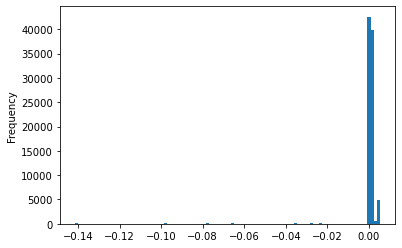

In [ ]:
ax = df_hosp_shap_values[hospital_columns[0]].plot.hist(bins=100)
print(f"Number of unique values for {hospital_columns[0]}: {df_hosp_shap_values[hospital_columns[0]].nunique()}")

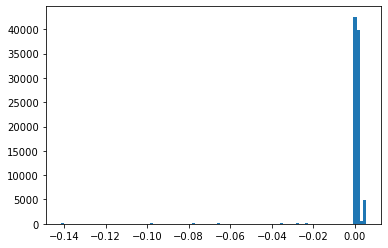

In [42]:
fig, axes = plt.subplots()
axes.hist(df_hosp_shap_values[hospital_columns[0]],bins=100);

Without restricting the axes to be on the same scale, can get a value on all subplots.

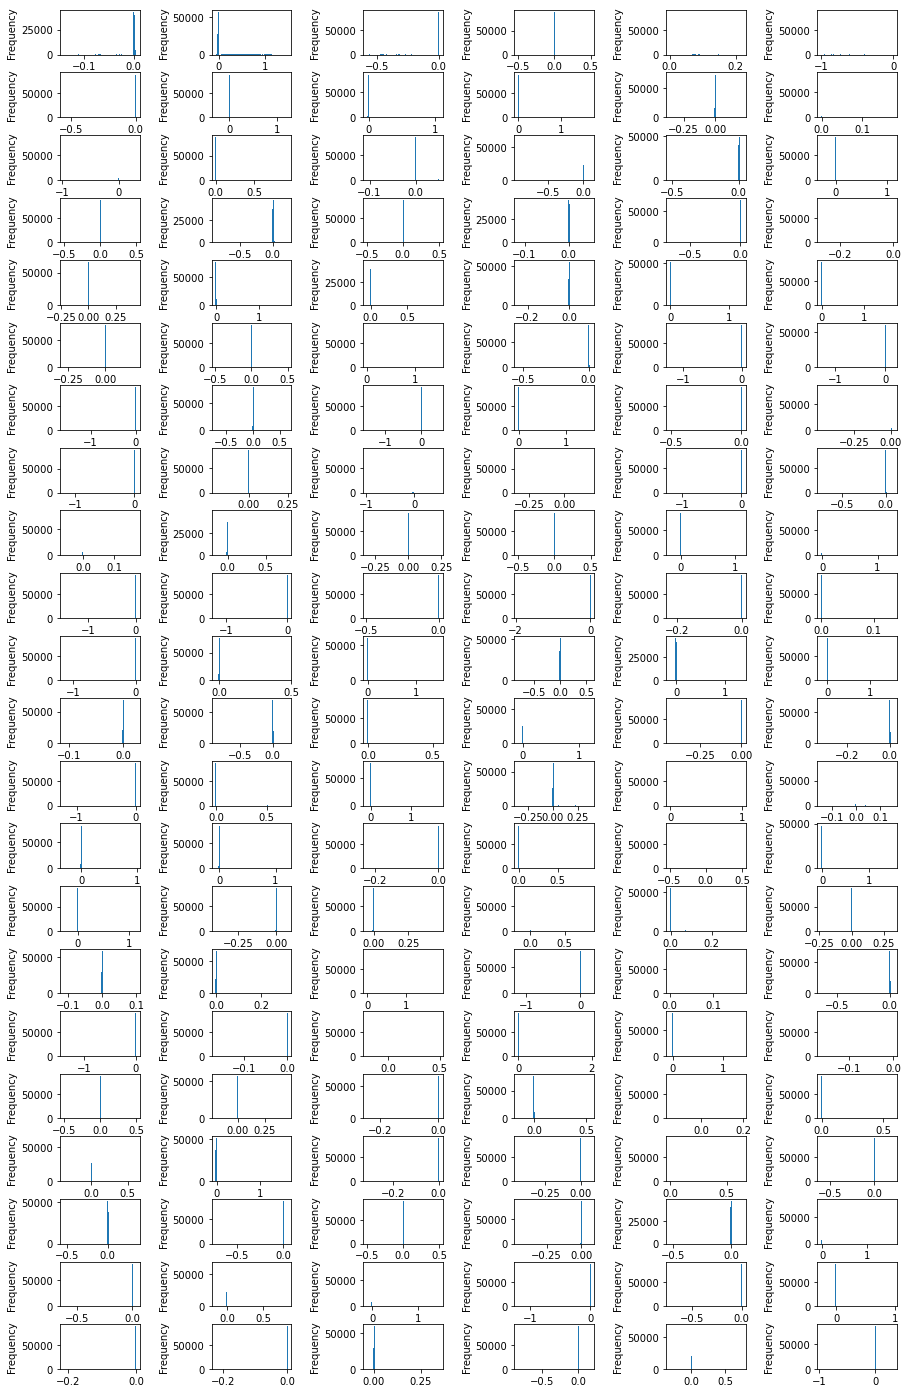

In [43]:
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for col in hospital_columns:
    
    df_hosp_shap_values[col].plot.hist(bins=100, ax=axes[count])
    count += 1

fig.set_figheight(25)
fig.set_figwidth(15)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

Create three matrix of histograms. 

One with all the instances to each hosptial
One with just the instances that attend each hosptial
One with just the instances that don't attend each hosptial.

One with all the instances to each hosptial

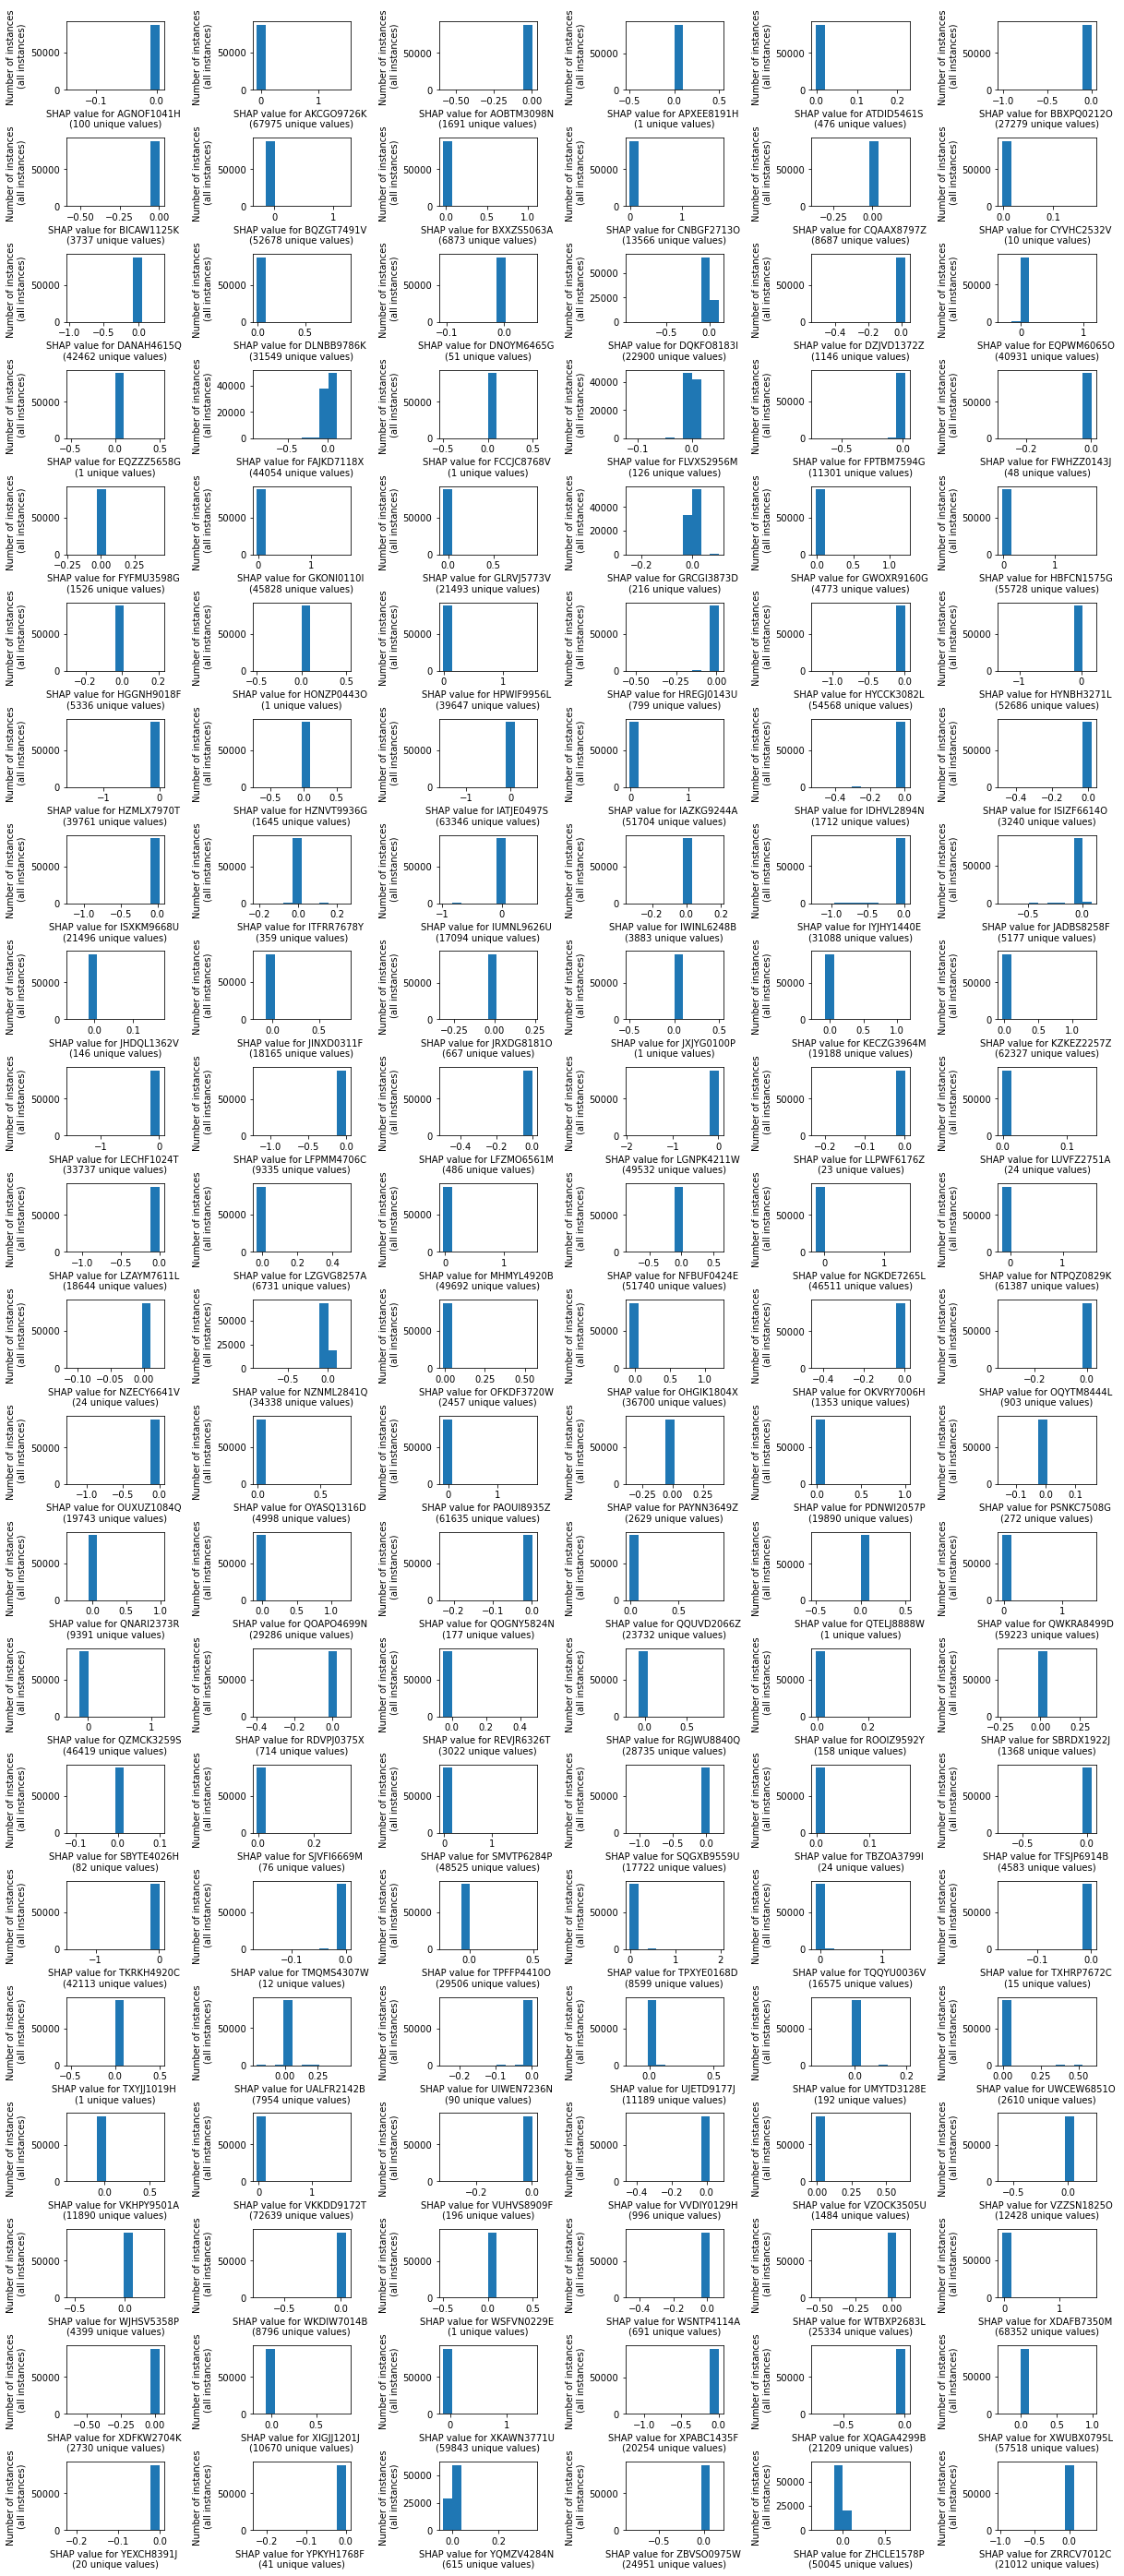

In [262]:
# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for col in hospital_columns:
    shap_values_all = df_hosp_shap_values[col]
    n_unique = shap_values_all.nunique()
    ax=axes[count]
    ax.hist(shap_values_all)# including bins=100 made it worse
    ax.set_xlabel(f"SHAP value for {col[5:]} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances \n(all instances)")
#    ax.set_ylim(0, y_max)
#    ax.set_xlim(x_min, x_max)
    count += 1

#        shap_values_attend.plot.hist(bins=100, ax=axes[count])

    
fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

One with just the instances that attend each hosptial

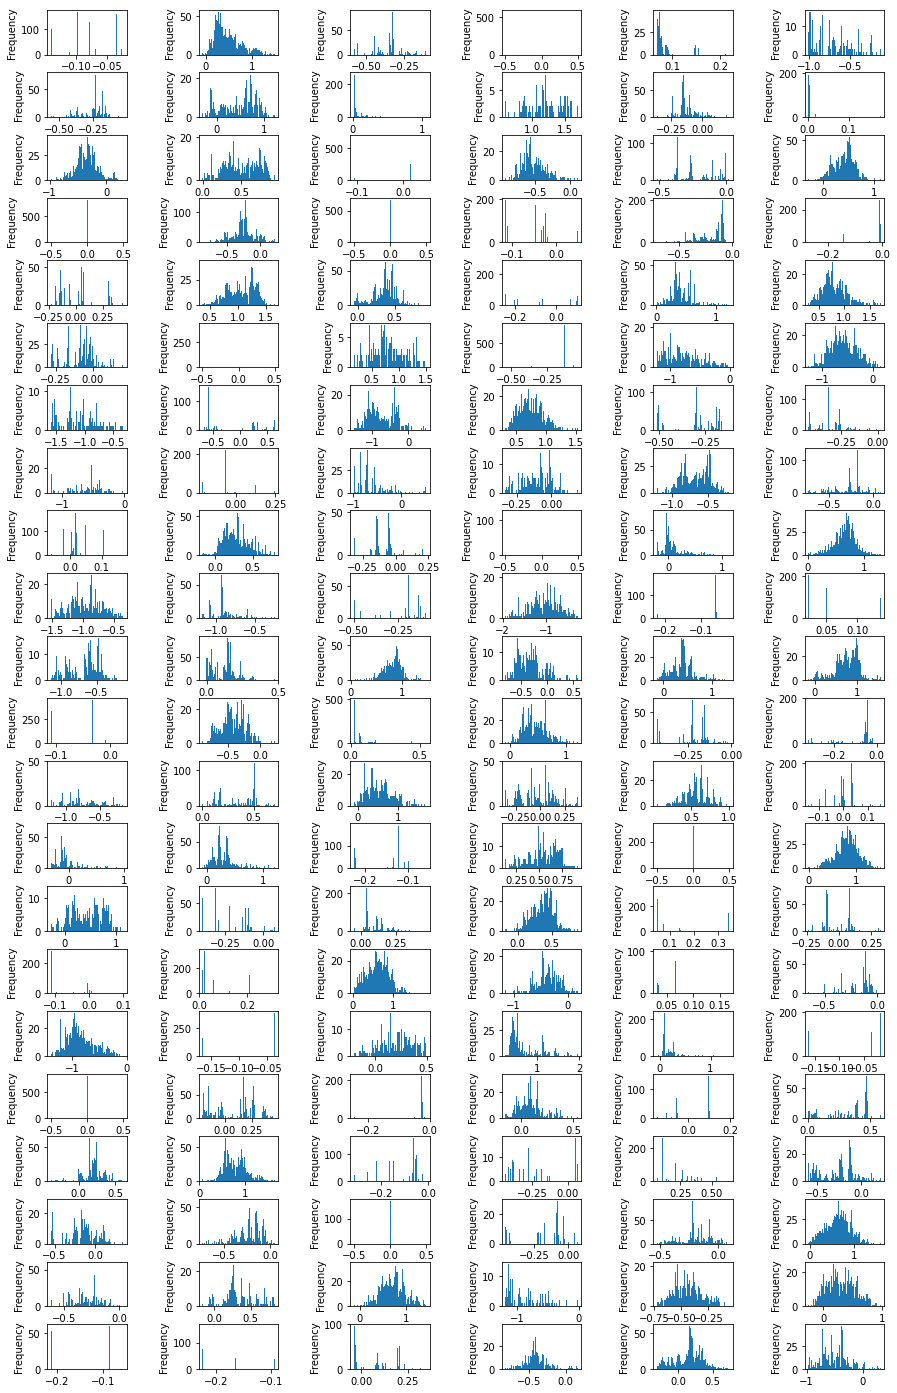

In [255]:
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for col in hospital_columns:
    
    mask = X_combined["Stroke team"] == col[5:] #drop "team_"
    shap_values_attend = df_hosp_shap_values[col][mask]
    shap_values_attend.plot.hist(bins=100, ax=axes[count])
#    mask = mask * 1
#    n_patients = mask.sum()
#    print(f"Number of patients {n_patients}")
#    print(f"Number of unique SHAP values for hospital {col[5:]} for those patients who attended: {shap_values_attend.nunique()}")
    count += 1

fig.set_figheight(25)
fig.set_figwidth(15)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

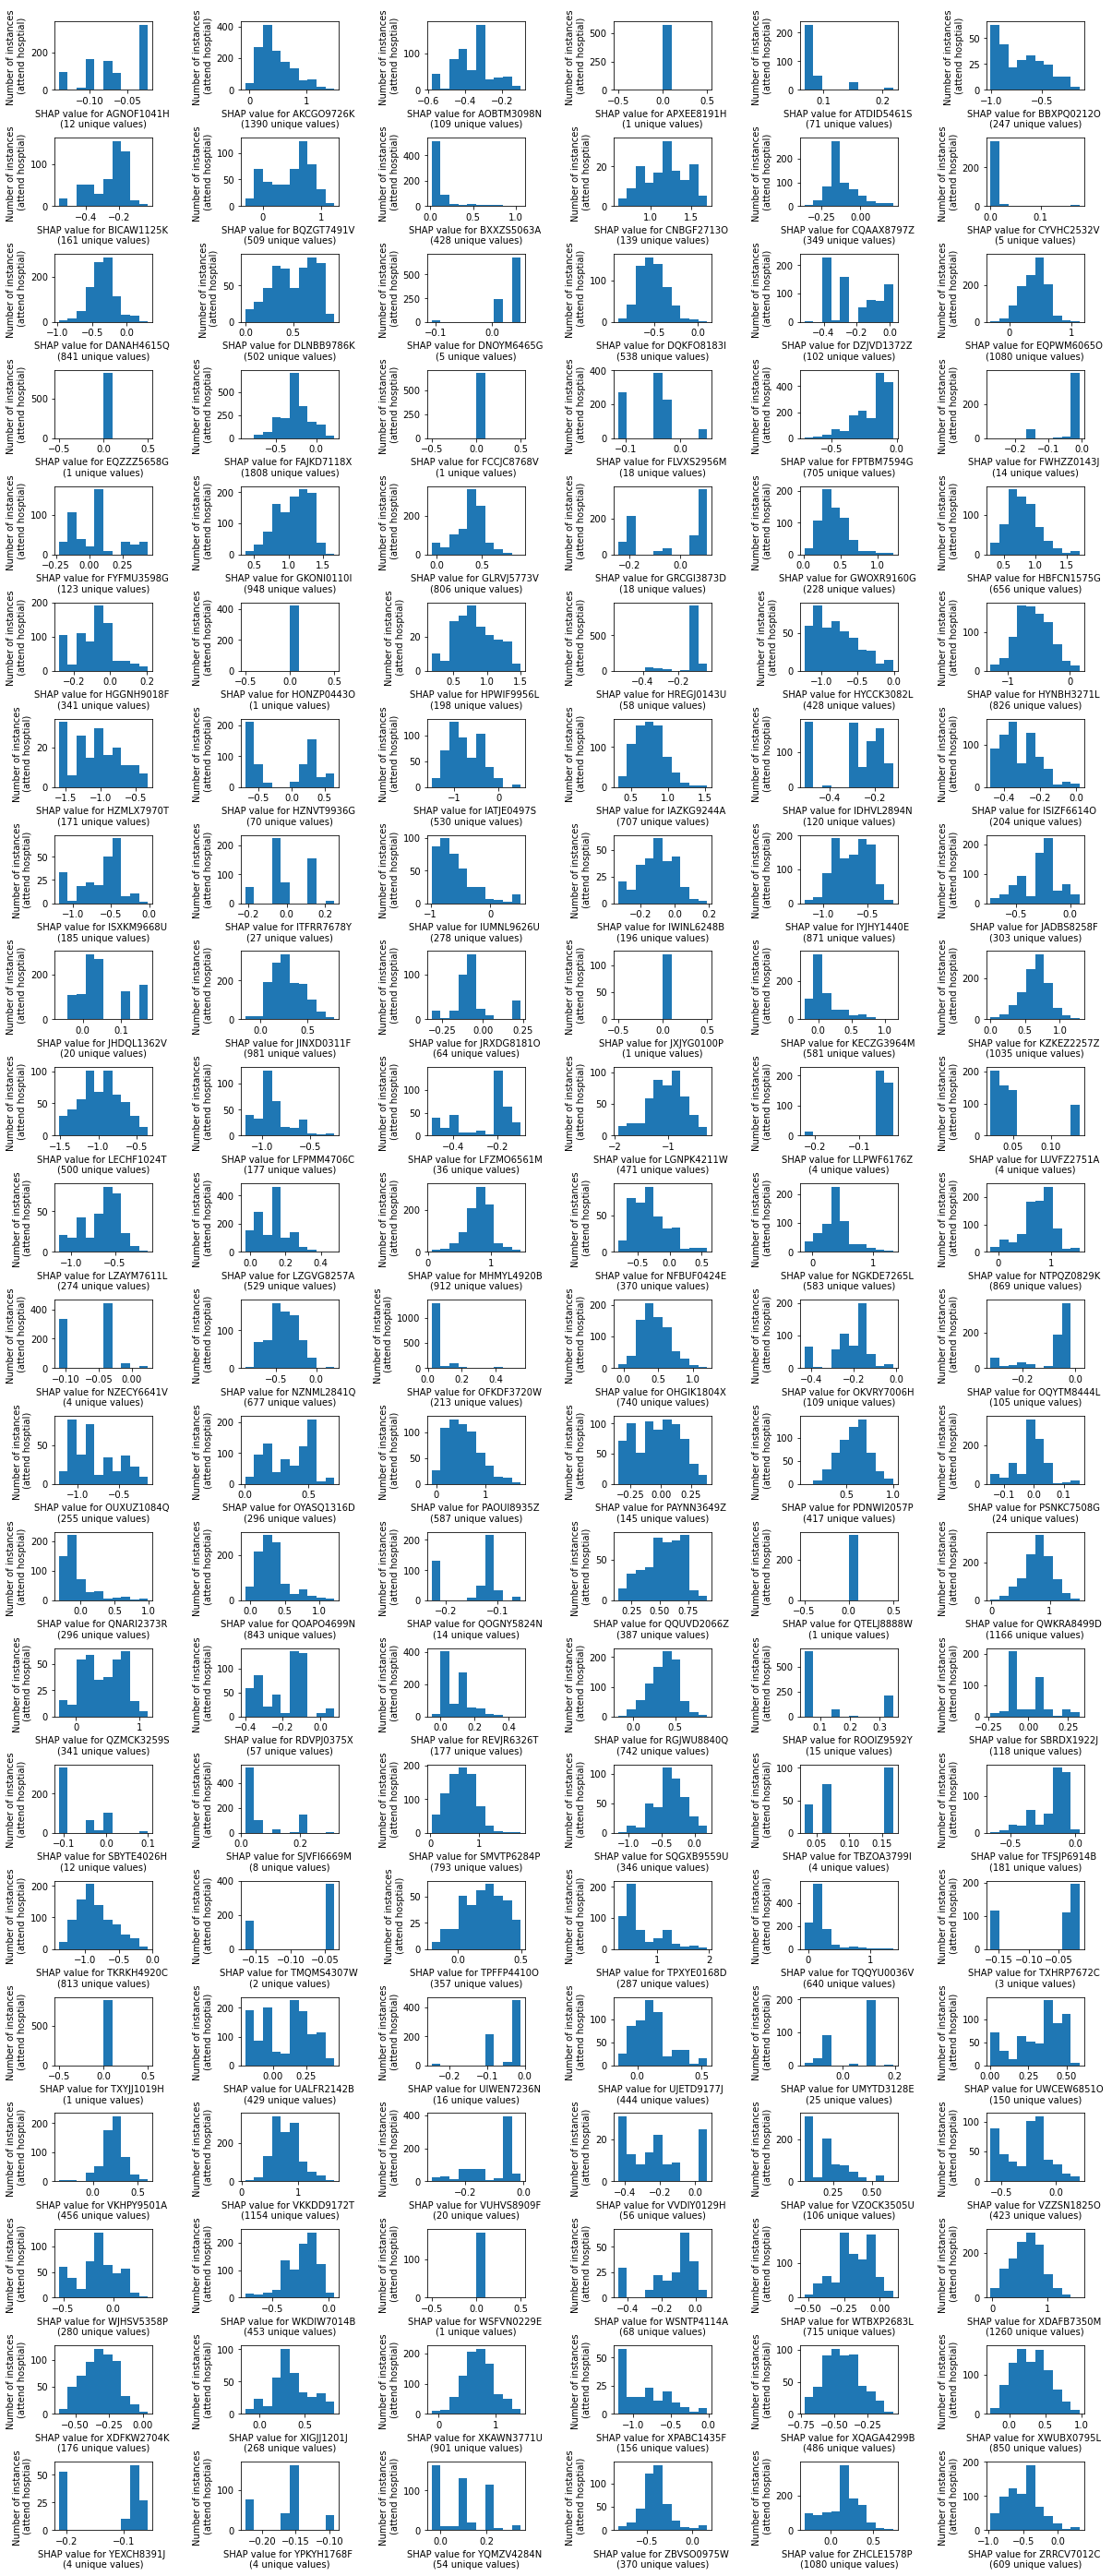

In [261]:
# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for col in hospital_columns:
    mask = X_combined["Stroke team"] == col[5:] #drop "team_"
    shap_values_attend = df_hosp_shap_values[col][mask]
    n_unique = shap_values_attend.nunique()
    ax=axes[count]
    ax.hist(shap_values_attend)# including bins=100 made it worse
    ax.set_xlabel(f"SHAP value for {col[5:]} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances \n(attend hosptial)")
#    ax.set_ylim(0, y_max)
#    ax.set_xlim(x_min, x_max)
    count += 1

#        shap_values_attend.plot.hist(bins=100, ax=axes[count])

    
fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

One with just the instances that don't attend each hosptial.

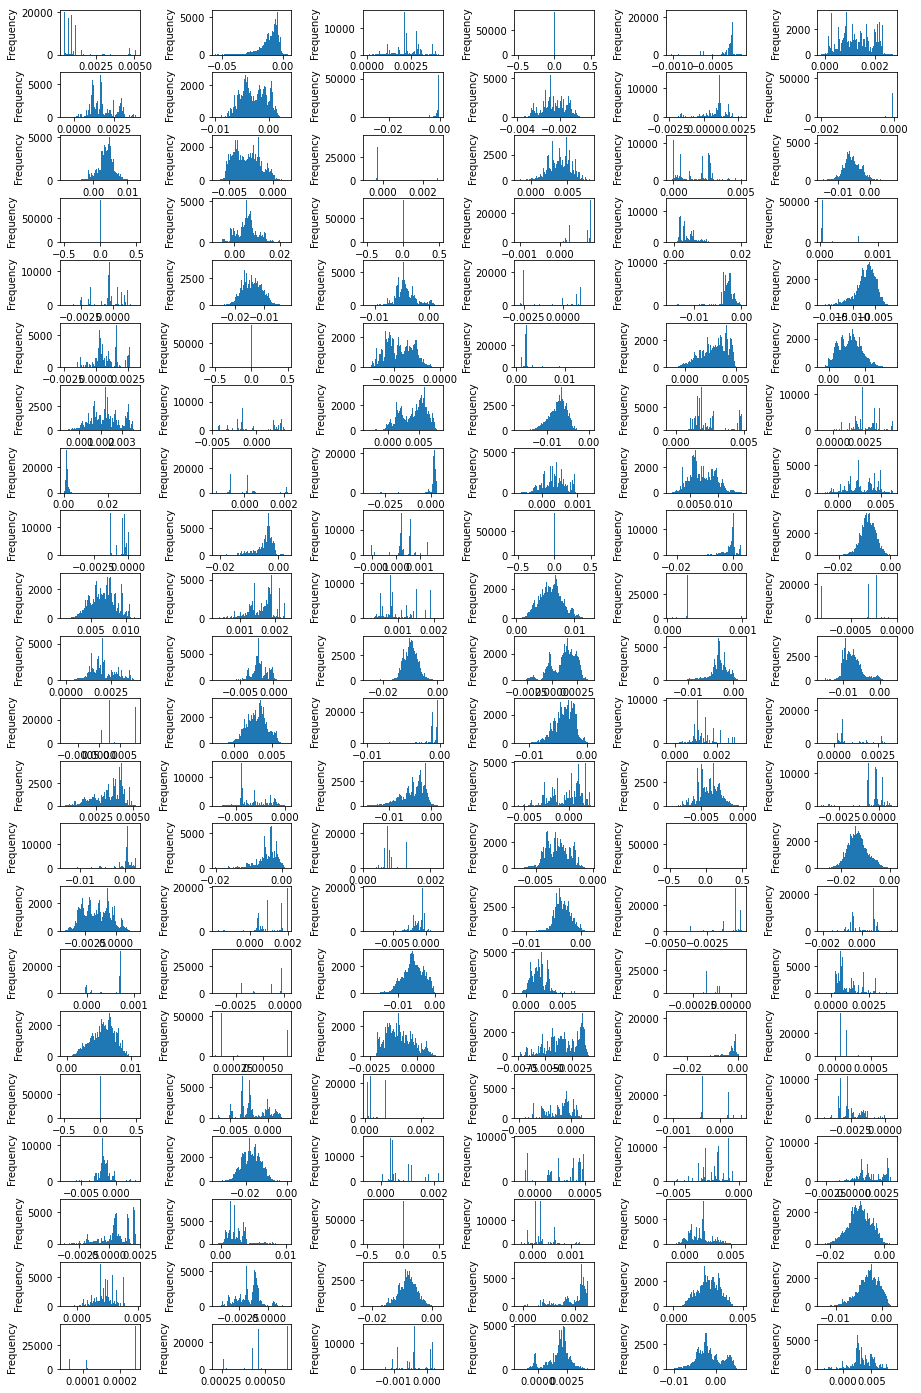

In [258]:
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for col in hospital_columns:
    
    mask = X_combined["Stroke team"] == col[5:] #drop "team_"
    mask = np.logical_not(mask)# Those that didn't attend
    shap_values_not_attend = df_hosp_shap_values[col][mask]
    shap_values_not_attend.plot.hist(bins=100, ax=axes[count])
#    mask = mask * 1
#    n_patients = mask.sum()
#    print(f"Number of patients {n_patients}")
#    print(f"Number of unique SHAP values for hosptial {col[5:]} for those patients who didn't attended: {shap_values_not_attend.nunique()}")
    count += 1

fig.set_figheight(25)
fig.set_figwidth(15)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

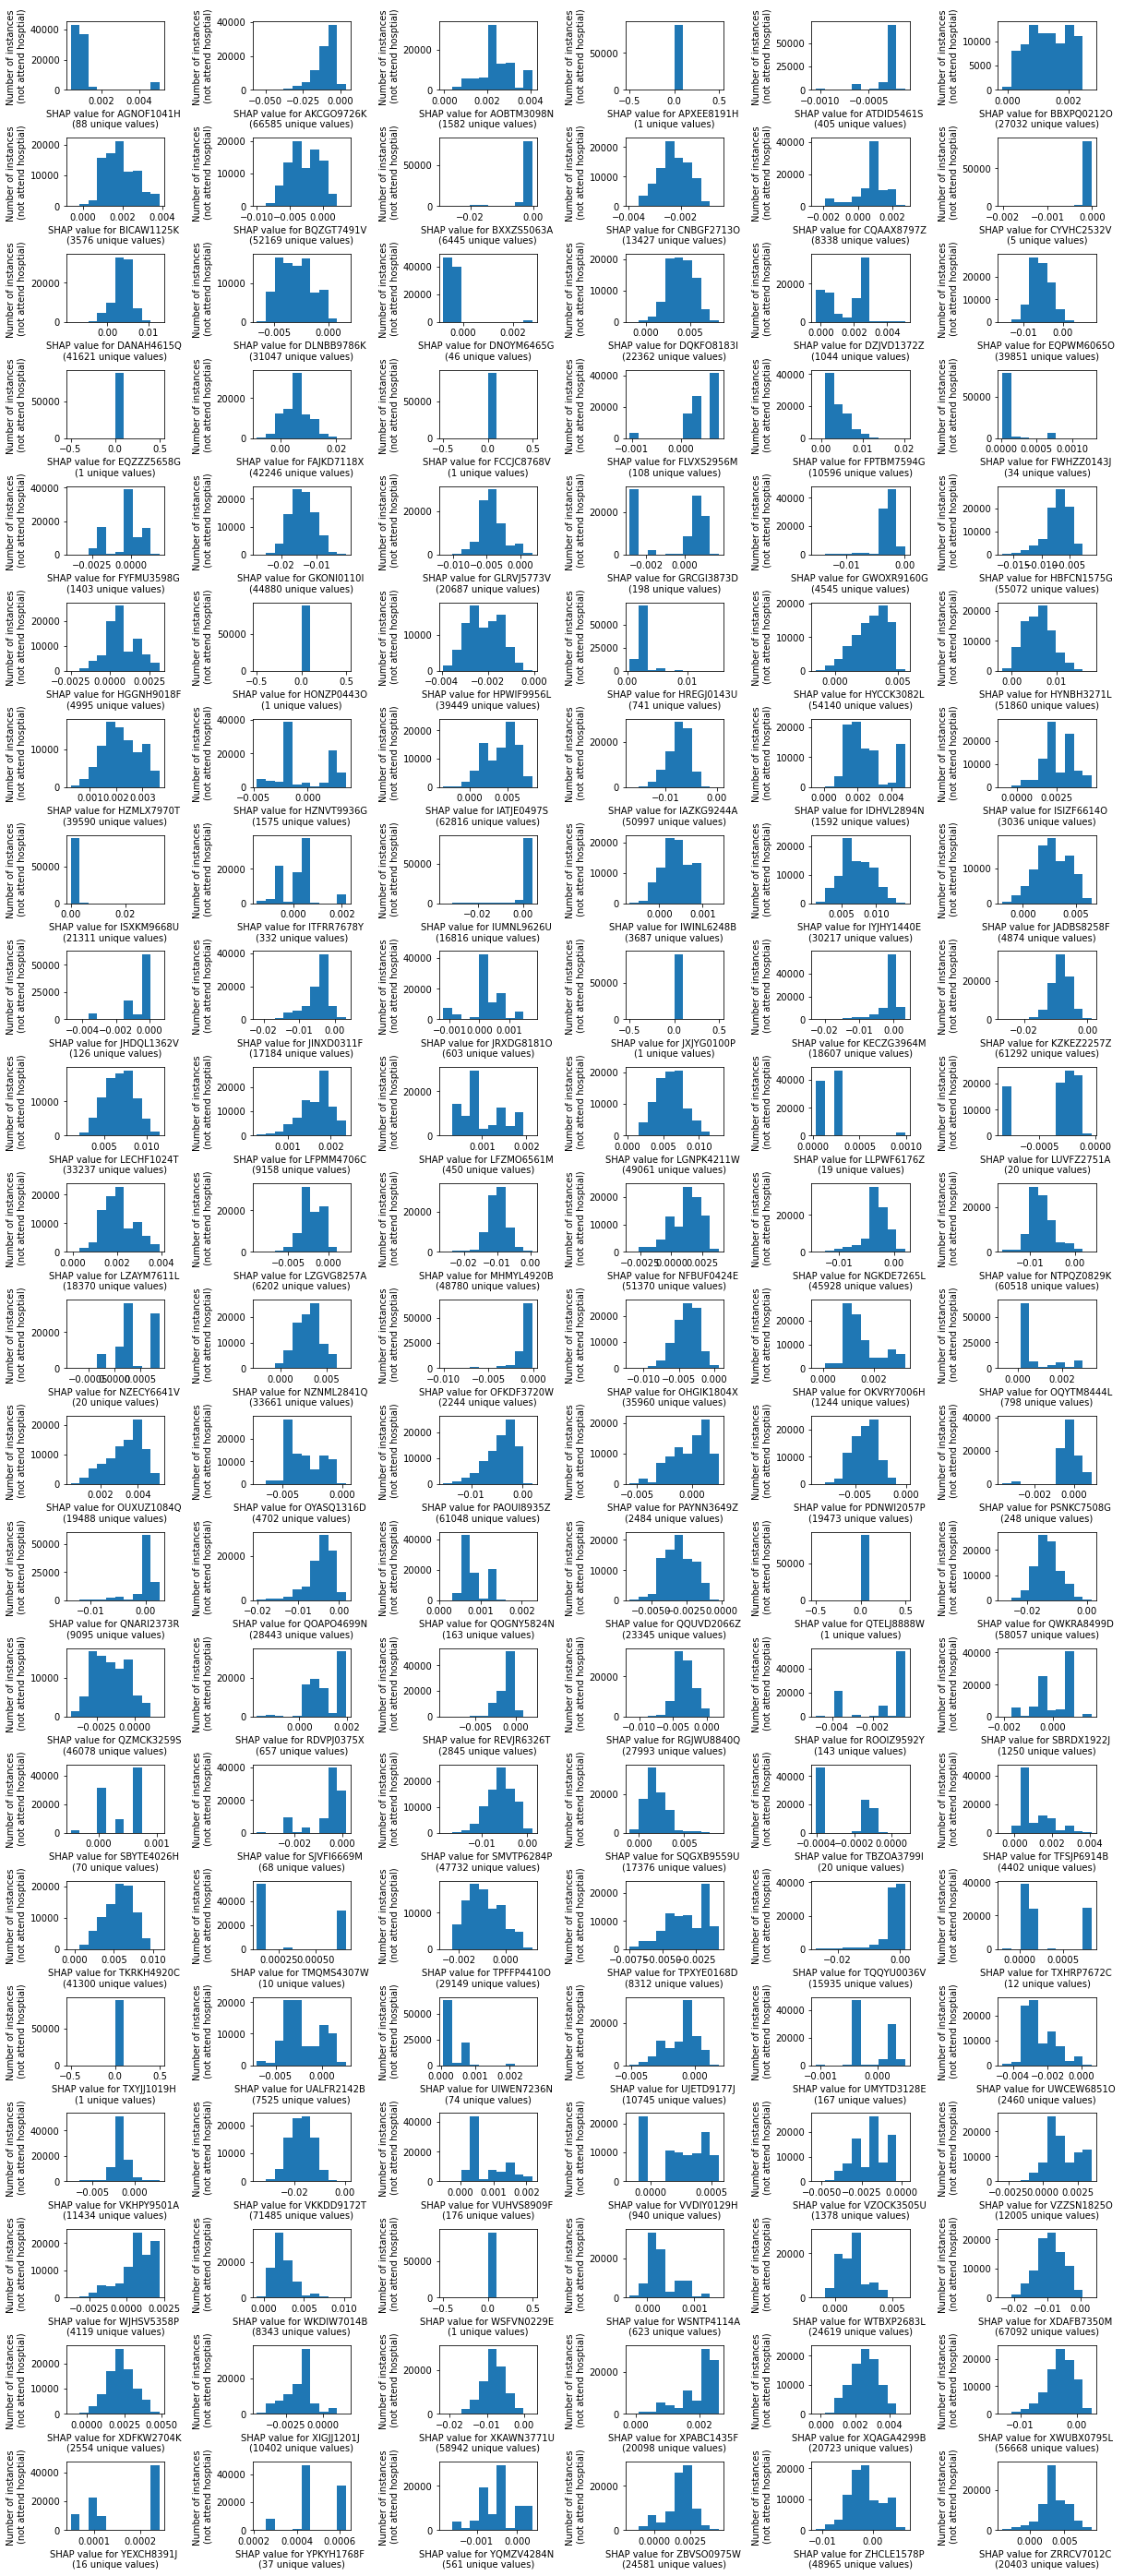

In [260]:
# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=22, 
    ncols=6)
axes = axes.ravel()

count = 0
for col in hospital_columns:
    mask = X_combined["Stroke team"] == col[5:] #drop "team_"
    mask = np.logical_not(mask)# Those that didn't attend
    shap_values_not_attend = df_hosp_shap_values[col][mask]
    n_unique = shap_values_not_attend.nunique()
    ax=axes[count]
    ax.hist(shap_values_not_attend)# including bins=100 made it worse
    ax.set_xlabel(f"SHAP value for {col[5:]} \n({n_unique} unique values)")
    ax.set_ylabel("Number of instances \n(not attend hosptial)")
#    ax.set_ylim(0, y_max)
#    ax.set_xlim(x_min, x_max)
    count += 1

#        shap_values_attend.plot.hist(bins=100, ax=axes[count])

    
fig.set_figheight(50)
fig.set_figwidth(20)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.7, wspace=0.9)
plt.show()

In [47]:
# X_combined has the original Stroke team column (use to get team attended)
# Extract the values for the relevant column per patient for the hosptial that they attended.
# Sum the rest

shap_attended_hospital = []
shap_not_attend_these_hospitals = []

# SHAP values for all hospitals
df_hosp_shap_values["all_stroke_teams"] = df_hosp_shap_values.sum(axis=1)

# Through each patient and get their stroke team
for index, row in df_hosp_shap_values.iterrows():

    # Get stroke team attended
    stroke_team = X_combined['Stroke team'].iloc[index]
    
    # Get SHAP value for the stroke team attended
    shap_attended_hospital.append(row[f"team_{stroke_team}"])

    # Sum the SHAP values for the stroke teams not attend 
    #    (sum the SHAP values for all stroke teams, minus the one attended)
    sum_rest = row["all_stroke_teams"] - row[f"team_{stroke_team}"]
    shap_not_attend_these_hospitals.append(sum_rest)

# Store in dataframe
df_hosp_shap_values["attended_stroke_team"] = shap_attended_hospital
df_hosp_shap_values["not_attended_stroke_teams"] = shap_not_attend_these_hospitals
                   
df_hosp_shap_values.head()

team_AGNOF1041H  team_AKCGO9726K  team_AOBTM3098N  team_APXEE8191H  \
0         0.000425        -0.004544         0.002133              0.0   
1         0.000688        -0.005805         0.002783              0.0   
2         0.000688        -0.013376         0.003087              0.0   
3         0.000688        -0.003726         0.001795              0.0   
4         0.004662        -0.006233         0.002781              0.0   

   team_ATDID5461S  team_BBXPQ0212O  team_BICAW1125K  team_BQZGT7491V  \
0        -0.000257         0.001842         0.000485        -0.003827   
1        -0.000241         0.000561         0.001729        -0.003741   
2        -0.000339         0.001068         0.001239        -0.006930   
3        -0.000242         0.001189         0.001472        -0.003931   
4        -0.000246         0.000269         0.001709        -0.003418   

   team_BXXZS5063A  team_CNBGF2713O  ...  team_XWUBX0795L  team_YEXCH8391J  \
0        -0.000428        -0.002353  ...        -0.004335         0.000242   
1        -0.000399        -0.002662  ...        -0.004736         0.000242   
2        -0.001318        -0.003079  ...        -0.004277         0.000110   
3        -0.000377        -0.002434  ...        -0.002319         0.000242   
4        -0.000390        -0.002434  ...        -0.002466         0.000242   

   team_YPKYH1768F  team_YQMZV4284N  team_ZBVSO0975W  team_ZHCLE1578P  \
0         0.000384        -0.000924         0.001592        -0.000849   
1         0.000632        -0.000350         0.001936        -0.002425   
2         0.000421        -0.000350         0.002117        -0.002792   
3         0.000632        -0.000583         0.001853        -0.002212   
4         0.000431        -0.000924         0.002366         0.000731   

   team_ZRRCV7012C  all_stroke_teams  attended_stroke_team  \
0         0.001919         -0.113772             -0.033326   
1         0.003180         -0.556337             -0.444107   
2         0.005288         -1.069877             -0.929185   
3         0.002744          0.612846              0.678743   
4         0.002848         -0.098175              0.000000   

   not_attended_stroke_teams  
0                  -0.080446  
1                  -0.112229  
2                  -0.140692  
3                  -0.065897  
4                  -0.098175  

[5 rows x 135 columns]

In [48]:
X_combined['Stroke team'].iloc[4]

'EQZZZ5658G'

In [ ]:
# Initialise list
new_shap_values = []

# For each set of feature SHAP values (for an instance)
for values in shap_values.values:
    
    # KP YOU ARE HERE
    # Take first 7 values, then the hospital attended, then the hosptials not attened.

    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    # Add to list
    new_shap_values.append(values_sum)

In [18]:
# Want to do a culmulative sum on the SHAP values for each instance. 
# Need to know how many one-hot features there are per feature.
# So store the number of categories for each feature, apart from the final feature (as this will take the rest).
# If it's continuous feature, then have value 1.

n_categories = []

for c in list(X_combined.columns)[:-1]:
    if  X_combined[c].dtype == object:
        n_categories.append(X_combined[c].nunique())
    else:
        n_categories.append(1)

In [19]:
# Initialise list
new_shap_values = []

# For each set of feature SHAP values (for an instance)
for values in shap_values.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    # Add to list
    new_shap_values.append(values_sum)

In [20]:
# Take deep copy of original Explainer object
shap_values_combined = copy.deepcopy(shap_values)

# Replace shap values
shap_values_combined.values = np.array(new_shap_values)

# Replace data with categorical feature values 
shap_values_combined.data = np.array(X_combined)

# Update feature names
shap_values_combined.feature_names = list(X_combined.columns)

### View SHAP values using beeswarm plot

The beeswarm plot gives a good visual representation of the general SHAP value pattern for the whole dataset. 

Each feature is shown on a separate row. It shows the distribution of the SHAP values for each feature. The colour represents the feature data value, and the shape of the data points represent the distribution of the features SHAP values (with a bulge representing a larger number of points, and a thin row representing fewer points). A SHAP value less than 0 (as seen on the x-axis) contributes to the likelihood that the passenger will not survive, whereas a SHAP value greater than 0 contributes to the likelihood that the passenger will survive.

The actual predction of whether a passenger will survive is the sum of each of the SHAP feature values and the SHAP base value.

Here we see that the first line on the beeswarm represents the feature male. A red data points represents a high data value (a male passenger), and a blue datapoint represents a low data value (a female passenger). Being male contributes to the likelihood that they will not survive, whereas being female contributes to the likelihood that they will survive. Female passengers can have a stronger contribution to the outcome (up to +4) than compared to the males (down to -2).

The third line on the beeswarm represents the feature Age. A red data points represents a high data value (an old passenger), a purple datapoint represents a mid point (a middle aged passenger) and a blue datapoint represents a child. The older the passenger the stronger the contribution to the likelihood that they will not survive, the younger the passenger the stronger the contribution to the likelihood that they will survive. There are more datapoints around the 0 SHAP value (which are coloured purple, and so represent the middle aged passengers) than at the extremes.

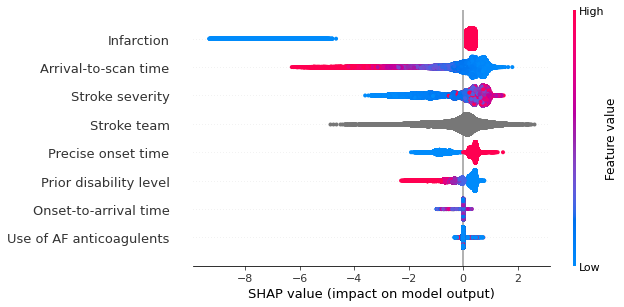

In [21]:
shap.plots.beeswarm(shap_values_combined,show=False)

Boxplot per categorical variable showing the spread of SHAP values for each categorical level.

In [ ]:
#get shaply values and data
stroketeam_values = shap_values_combined[:,"Stroke team"].values
stroketeam_data = shap_values_combined[:,"Stroke team"].data

#split odor shap values based on odor category
stroketeam_categories = list(set(stroketeam_data))

# Create dictionary for the Label with frequency, to use for the boxplot label
# KP NEED TO DO THIS
dict_freq = {}
#for o in embarked_categories:
#    dict_freq[f'{o}'] = []
    
stroketeam_groups = []
for o in stroketeam_categories:
    relevant_values = stroketeam_values[stroketeam_data == o]
    stroketeam_groups.append(relevant_values)
    dict_freq[f'{o}'] = relevant_values.shape
    
#replace categories with labels
stroketeam_labels = {'C':f'Cherbourg\n(n={dict_freq["C"][0]})',
                     'Q':f'Queenstown\n(n={dict_freq["Q"][0]})', 
                     'S':f'Southampton\n(n={dict_freq["S"][0]})',
                     '0':f'Missing\n(n={dict_freq["0"][0]})'}

labels = [stroketeam_labels[u] for u in stroketeam_categories]

#plot boxplot
plt.figure(figsize=(8, 5))

plt.boxplot(stroketeam_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Stroke team',size=15)
plt.show()
#plt.savefig(path.format('boxplot.png'),dpi=100,bbox_inches='tight')

## Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature).

In [22]:
%%time

filename = f'./output/12a_xgb_shap_interaction_array.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        shap_interaction = pickle.load(filehandler)
else:
    # Get SHAP interaction values
    shap_interaction = explainer.shap_interaction_values(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_interaction, filehandler)

CPU times: user 0 ns, sys: 2.56 s, total: 2.56 s
Wall time: 3.53 s


SHAP interaction values have a matrix of values (per pair of features) per instance.\
In this case, each of the 891 instances has a 4x4 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

In [23]:
shap_interaction.shape

(88792, 139, 139)

Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

In [24]:
shap_interaction[0]

array([[ 6.5910852e-01,  4.2939126e-02,  2.8695703e-02, ...,
        -2.4725590e-04,  1.9933996e-04, -9.9656335e-04],
       [ 4.2939067e-02,  3.1778699e-01,  4.6772063e-02, ...,
         7.2282273e-07,  0.0000000e+00,  1.1991942e-06],
       [ 2.8695643e-02,  4.6772093e-02,  7.7302808e-01, ...,
        -3.1074975e-05,  5.7468645e-04,  7.5616292e-05],
       ...,
       [-2.4724007e-04,  7.1525574e-07, -3.1054020e-05, ...,
         2.3201099e-03,  0.0000000e+00,  0.0000000e+00],
       [ 1.9934773e-04,  0.0000000e+00,  5.7467818e-04, ...,
         0.0000000e+00, -2.4604283e-03,  0.0000000e+00],
       [-9.9658966e-04,  1.2069941e-06,  7.5638294e-05, ...,
         0.0000000e+00,  0.0000000e+00,  3.5439148e-03]], dtype=float32)

Represent the shap-interactions without one-hot encoded features (that is to represent Embarked as a single column by summing the relevant OHE)

In [26]:
# Want to do a culmulative sum on the SHAP interactions for each instance. 
# Need to know how many one-hot features there are per feature.
# So store the number of categories for each feature, apart from the final feature (as this will take the rest).
# If it's continuous feature, then have value 1.
#  Want result [1,1,1].

n_categories = []

for c in list(X_combined.columns):
    if  X_combined[c].dtype == object:
        n_categories.append(X_combined[c].nunique())
    else:
        n_categories.append(1)

Represent the shap_interaction.values as a value per feature (sum up the one-hot encoded features).

In [27]:
def sum_matrix_elements(matrix, n_categories):
    
    '''
    # Here are three examples to show what this function does.
    
    1. Start with a 3x3 matrix

    matrix = np.array([[1,2,3],[4,5,6],[7,8,9]])

    If define the first group to have 1 column, and second group to have 2 columns
    n_categories = [1,2]

    # Want result to be a 2x2 matrix, such that:
    m_result = np.array[[1,2+3],[4+7,5+6+8+9]]
    m_result = np.array[[1,5],[11,28]]

    2. Start with a 3x3 matrix

    matrix = np.array([[1,2,3],[4,5,6],[7,8,9]])

    If define the first group to have 2 columns, and second group to have 1 column
    n_categories = [2, 1]

    # Want result to be a 2x2 matrix, such that:
    m_result = np.array[[1+2+4+5,3+6],[7+8,9]]
    m_result = np.array[[12,9],[15,9]]

    3. Start with a 4x4 matrix

    matrix = np.array([[1,2,3,4],[5,6, 7, 8],[9,10,11,12],[13,14,15,16]])
    
    If define the first group to have 2 columns, and second group to have 2 columns
    n_categories = [2,2]

    # Want result to be a 2x2 matrix, such that:
    m_result = np.array[[1+2+5+6,3+4+7+8],[9,10,13,14],[11,12,15,16]]
    m_result = np.array[[14,22],[46,54]]

    '''
    
    #initialise matrix result
    m_result = np.zeros((len(n_categories), len(n_categories)))

    end_r = 0
    new_r = 0
    
    # go through the rows in the groups as determined in the n_categories
    for r in n_categories:
        # New block of rows, so start from the first column
        new_c = 0
        end_c = 0
        #Set start row to the end of the previous group
        start_r = end_r
        #and the end row to the number of rows as defined by the number in the group
        end_r = (start_r + r)

        # go through the rows in the groups as determined in the n_categories
        for c in n_categories:
            #Set start column to the end of the previous group
            start_c = end_c
            #and the end column to the number of columns as defined by the number in the group
            end_c = (start_c + c)
            #The entry is the sum of the values in the original matrix
            m_result[new_r, new_c] = matrix[start_r:end_r, start_c:end_c].sum()
            #Move column index on one (for the result matrix)
            new_c+=1
        # Move row index on one (for the result matrix)
        new_r+=1
    return(m_result)

In [28]:
#initialise matrix result
shap_interaction_combined = np.zeros((shap_interaction.shape[0], len(n_categories), len(n_categories)))

i = 0
# for each instance, get the interaction matrix
for matrix in shap_interaction:
    # combine the relevant elements of the interaction matrix (the one-hot encoded features)
    #    and store result in array
    shap_interaction_combined[i,:,:] = sum_matrix_elements(matrix, n_categories)
    i+=1

SHAP interaction values have a matrix of values (per pair of features) per instance.

In this case, each of the 891 instances has a 4x4 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions, and the fourth feature now being represented by 1 columns and not 3).

In [29]:
shap_interaction_combined.shape

(88792, 8, 8)

In [30]:
print(f"Sum of SHAP from two sources: {shap_interaction.sum().sum()} & {shap_interaction_combined.sum().sum()}")
print(f"Sum of SHAP from two sources: {shap_interaction[1].sum()} & {shap_interaction_combined[1].sum()}")

Sum of SHAP from two sources: -134835.4375 & -134835.05720020126
Sum of SHAP from two sources: 1.8863579034805298 & 1.8863582193735056


### SHAP interaction matrix: show mean absolute values
Here we see the absolute mean of the SHAP interaction values for all of the instances.\
The values on the diagonal show the main effect for the feature, and the other values show the SHAP interaction for pairs of features (these are symetrical across the diagonal)

In [31]:
mean_abs_interactions = pd.DataFrame(
    np.abs(shap_interaction_combined).mean(axis=(0)),
    index=X_combined.columns, columns=X_combined.columns)

mean_abs_interactions.round(2)

Arrival-to-scan time  Infarction  Stroke severity  \
Arrival-to-scan time                      0.95        0.09             0.08   
Infarction                                0.09        1.43             0.09   
Stroke severity                           0.08        0.09             0.86   
Precise onset time                        0.03        0.06             0.05   
Prior disability level                    0.03        0.04             0.04   
Stroke team                               0.10        0.04             0.08   
Use of AF anticoagulents                  0.00        0.00             0.00   
Onset-to-arrival time                     0.00        0.00             0.00   

                          Precise onset time  Prior disability level  \
Arrival-to-scan time                    0.03                    0.03   
Infarction                              0.06                    0.04   
Stroke severity                         0.05                    0.04   
Precise onset time                      0.58                    0.03   
Prior disability level                  0.03                    0.41   
Stroke team                             0.05                    0.04   
Use of AF anticoagulents                0.00                    0.00   
Onset-to-arrival time                   0.00                    0.00   

                          Stroke team  Use of AF anticoagulents  \
Arrival-to-scan time             0.10                      0.00   
Infarction                       0.04                      0.00   
Stroke severity                  0.08                      0.00   
Precise onset time               0.05                      0.00   
Prior disability level           0.04                      0.00   
Stroke team                      0.56                      0.00   
Use of AF anticoagulents         0.00                      0.01   
Onset-to-arrival time            0.00                      0.00   

                          Onset-to-arrival time  
Arrival-to-scan time                       0.00  
Infarction                                 0.00  
Stroke severity                            0.00  
Precise onset time                         0.00  
Prior disability level                     0.00  
Stroke team                                0.00  
Use of AF anticoagulents                   0.00  
Onset-to-arrival time                      0.01

### The proportion of SHAP that is from the interactions: calculated from the absolute mean
Looking at all of the instances together, what proportion of the SHAP value comes from the SHAP interations

In [32]:
total_shap = mean_abs_interactions.sum().sum()

interaction_shap = (mean_abs_interactions.sum().sum() - 
                    np.diagonal(mean_abs_interactions).sum().sum())

print(f'The proportion of the SHAP values coming from the interactions are: '
      f'{interaction_shap/total_shap:0.3f}')
print(f'The proportion of the SHAP values coming from the main effects are: '
      f'{1 - (interaction_shap/total_shap):0.3f}')

The proportion of the SHAP values coming from the interactions are: 0.269
The proportion of the SHAP values coming from the main effects are: 0.731


### The proportion of SHAP that is from the interactions: calculated per instance from the absolute values
Looking at each instances, what proportion of the SHAP value comes from the SHAP interations. Show the range of proportions (one per instance) as a histogram.

Text(0, 0.5, 'Number of instances')

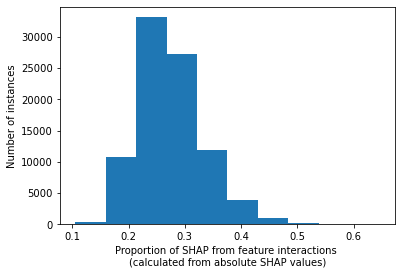

In [33]:
# sum the absolute interaction matrix per instance
abs_total_shap_per_instance = np.abs(shap_interaction_combined).sum(axis=(1,2))

# Initialise list
proportion_interaction = []

# For each instance
for i in range(abs_total_shap_per_instance.shape[0]):
    # sum the absolute feature interactions (off diagonal positions)
    abs_interaction = (abs_total_shap_per_instance[i] - 
                       np.diagonal(np.abs(shap_interaction_combined[i])).sum())
    # calculate the proportion from feature interactions
    proportion_interaction.append(
                abs_interaction / abs_total_shap_per_instance[i])

# plot as histogram
plt.hist(proportion_interaction);
plt.xlabel("Proportion of SHAP from feature interactions \n"
           "(calculated from absolute SHAP values)")
plt.ylabel("Number of instances")

### SHAP interaction matrix: represented as histograms 

Show the distribution of all of the instance values for each SHAP interation and SHAP main effect.

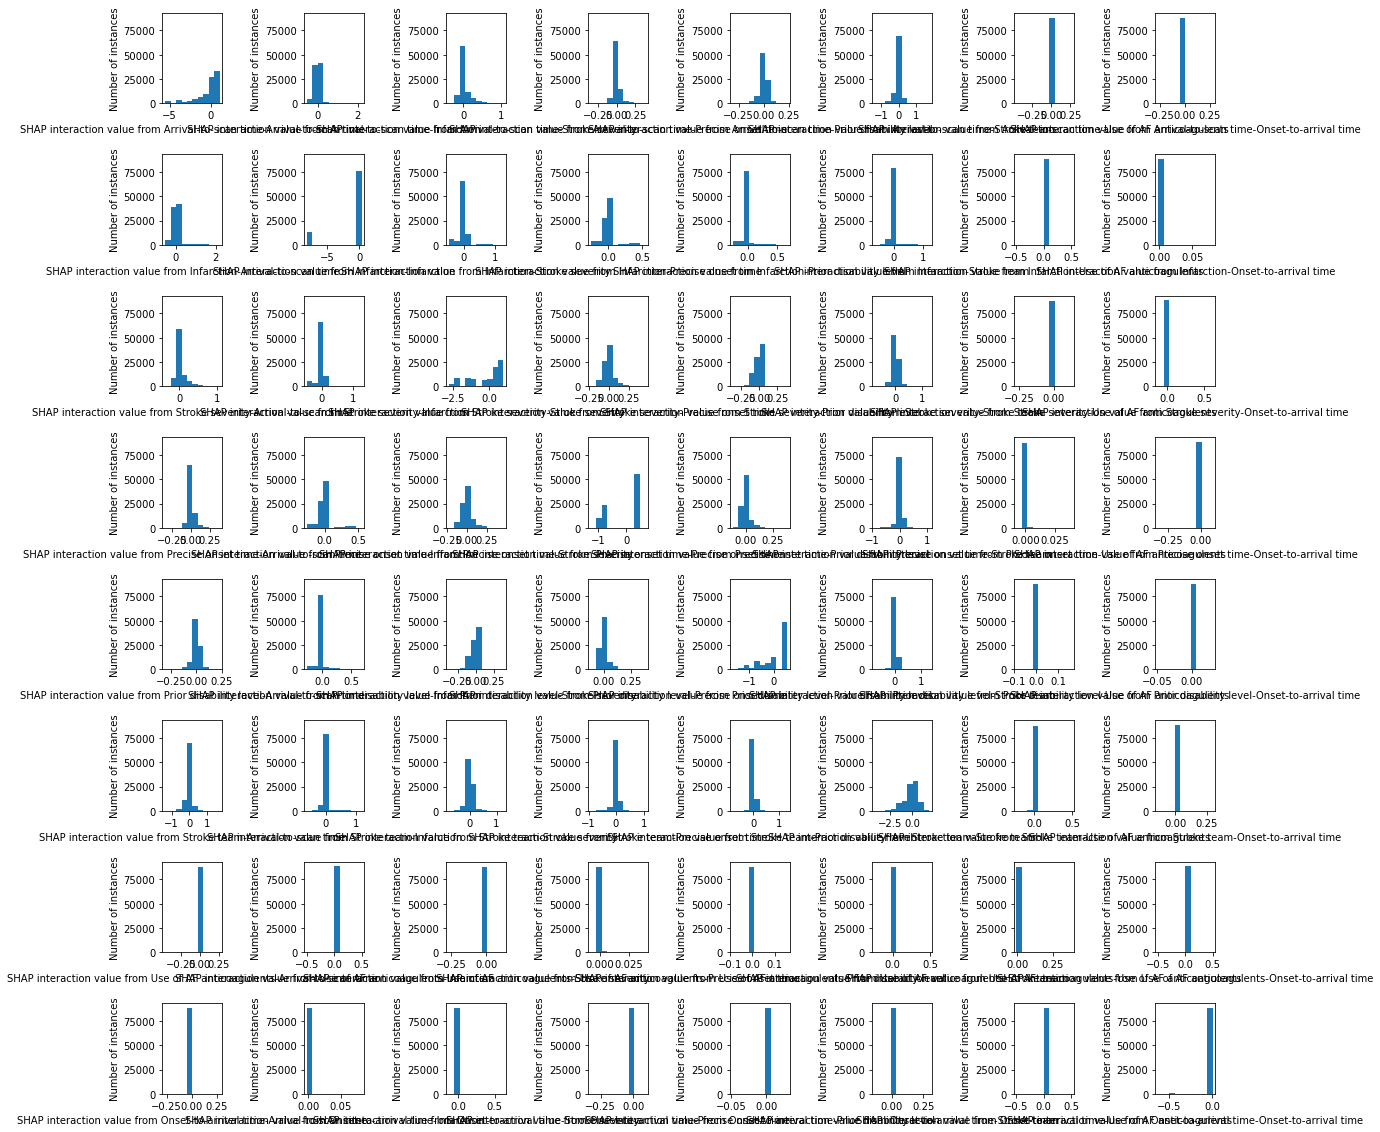

In [34]:
features = X_combined.columns
n_features = len(features)

# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
fig, axes = plt.subplots(1)
for i in range(n_features):
    for j in range(n_features):    
        axes.hist(shap_interaction_combined[:,i,j])
        ylims = axes.get_ylim()
        # Store if greater than found so far
        y_max = max(y_max, ylims[1])
# Don't display plot
plt.close(fig)

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()        

count = 0
for i in range(n_features):
    for j in range(n_features):    
        ax=axes[count]
        ax.hist(shap_interaction_combined[:,i,j])
        ax.set_xlabel(f"SHAP interaction value from \n{features[i]}-{features[j]}")
        ax.set_ylabel("Number of instances")
        ax.set_ylim(0, y_max)
        count += 1
        
fig.set_figheight(16)
fig.set_figwidth(16)
plt.tight_layout(pad=2)
#fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

## Show a worked example for the first instance
Start with the feature values, and then show the SHAP values and how they can be represented as main effect and interactions. Also show that by summing them along with the base value gives the model output.

In [36]:
instance = 0
target_category = ["not thrombolysis", "thrombolysis"]
# Show data for first example
print ('Showing a worked example for the first instance')
print ('==============================================')
print ()
print ('------------------')
print ('Feature data values')
print ('------------------')
print (X_combined.iloc[instance])

# Model output
prob_thrombolysis = y_proba[instance][1]
logodds_thrombolysis = np.log(prob_thrombolysis/(1 -prob_thrombolysis))
print ()
print ('-------------------')
print ('Model output values')
print ('-------------------')
print (f'1. Model probability [not thrombolysis, thrombolysis]: ' +
       f'{np.round(y_proba[instance],3)}')
##print ('------------')
#print (np.round(y_proba[instance],3))
print (f'\n2. Model log odds thrombolysis: {round(logodds_thrombolysis,3)}')
#print ('------------')
#print(round(logodds_survive,3))
cat = np.int(y_pred[instance])
print (f'\n3. Model classification: {cat} ({target_category[cat]})')
##print ('------------')
#print (y_pred[instance])

print ()
print ('-----------------')
print ('SHAP base value (log odds)')
print ('---------------')
print (shap_values_combined.base_values[instance])
print ('\nNote: This is the same value for all of the instances. This is the ' +
       'models best guess without additional knowledge about the instance')
 
#example_shap = pd.DataFrame(shap_values.values[instance],columns=X.columns)
print ()
print ('-----------------')
print ('SHAP values (log odds)')
print ('------------')
# print (example_shap)
for i in range(len(shap_values_combined.values[instance])):
    v = shap_values_combined.values[instance][i]
    print (f'{X_combined.columns.values[i]}: {v:0.3f}')
v = shap_values_combined.values[instance].sum()
print (f'Total = {v:0.3f}')

print ('\nNote: These are patient dependent')
#print ()
#print ('-----------------')
#print ('Sum of SHAP values')
#print ('------------')
#print (shap_values.values[instance].sum())

print (f'\nThe "Model log odds thrombolysis" value ({logodds_thrombolysis:0.3g}, ' +
       f'see above) is calculated by adding up the SHAP base value ' +
       f'({shap_values_combined.base_values[instance]:0.3f}, see above) with ' +
       f'all of the SHAP values for each feature ' +
       f'({shap_values_combined.values[instance].sum():0.3f}, see above)')
print (f'{shap_values_combined.base_values[instance]:0.3f} + ' +
       f'{shap_values_combined.values[instance].sum():0.3f} = ' +
       f'{logodds_thrombolysis:0.3f}')

# SHAP interaction values for first employee
example_interaction = pd.DataFrame(shap_interaction_combined[instance],
                                   index=X_combined.columns,
                                   columns=X_combined.columns)
row_total = example_interaction.sum(axis=0)
column_total = example_interaction.sum(axis=1)
total = example_interaction.sum().sum()
example_interaction['Total'] = row_total
example_interaction.loc['Total'] = column_total
example_interaction.loc['Total']['Total'] = total

print ()
print ('-----------------')
print ('SHAP interactions (log odds)')
print ('-----------------')
print ('\n* Each instance has a different SHAP value for the features. This ' +
       'is because the model is also capturing the interaction between pairs ' +
       'of features, and how that contributes to the features SHAP value.')
print ('* Each feature has a SHAP main effect (on the diagonal) and a SHAP ' +
       'interaction effect with each of the other features (off the diagonal)')
print ('* SHAP interaction is split symetrically, eg. age-male is the same ' +
       'as male-age.')
print ('* For each feature, the sum of the SHAP main effect and all of its ' +
       'SHAP interaction values = SHAP value for the feature (shown in ' +
       '"Total", and can be compared to the SHAP values above)')
print ()
print (example_interaction)

print ('------------------')
print ('\nThe model prediction for each instance can be arrived at by ' +
       'starting at the SHAP base value, and adding on the SHAP values from ' +
       'all of the the main effects (one per feature) and from all of the ' +
       'SHAP interactions (two per pair of features).')

Showing a worked example for the first instance

------------------
Feature data values
------------------
Arrival-to-scan time              17.0
Infarction                           1
Stroke severity                   14.0
Precise onset time                   1
Prior disability level               0
Stroke team                 TXHRP7672C
Use of AF anticoagulents             0
Onset-to-arrival time            186.0
Name: 0, dtype: object

-------------------
Model output values
-------------------
1. Model probability [not thrombolysis, thrombolysis]: [0.147 0.853]

2. Model log odds survive: 1.757

3. Model classification: 1 (thrombolysis)

-----------------
SHAP base value (log odds)
---------------
-1.0995926

Note: This is the same value for all of the instances. This is the models best guess without additional knowledge about the instance

-----------------
SHAP values (log odds)
------------
Arrival-to-scan time: 0.821
Infarction: 0.456
Stroke severity: 0.924
Precise onset time: 

## Sum of the SHAP value components (base + main effects + interactions) = model prediction 
We've seen a worked through example for one instance that the sum of the SHAP interactions and main effects and base value equals the model output (the log odds of predicted P). 

Here we show that it holds for all of the instances.

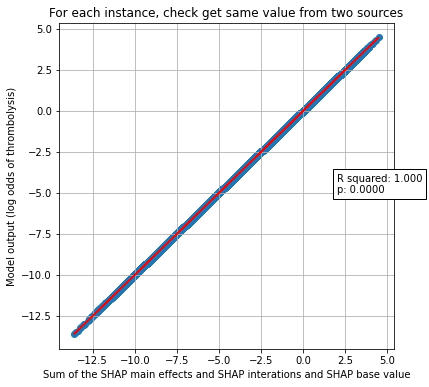

In [37]:
# Model output: probability thrombolysis
prob_thrombolysis = y_proba[:,1]
# Calculate log odds
logodds_thrombolysis = np.log(prob_thrombolysis/(1 -prob_thrombolysis))

# sum each matrix to get a value per instance
total_shap_per_instance = shap_values_combined.base_values + shap_interaction_combined.sum(axis=(1,2))

x = total_shap_per_instance
y = logodds_thrombolysis

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x, y)
plt.plot (x, y_pred, color = 'red')
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1.text(2, -5, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel("Sum of the SHAP main effects and SHAP interations and SHAP base value")
ax1.set_ylabel("Model output (log odds of thrombolysis)")
plt.title("For each instance, check get same value from two sources")
plt.grid()
#plt.savefig('./output/scatter_plot_hosp_shap_vs_10k_thrombolysis.jpg', dpi=300,
#    bbox_inches='tight', pad_inches=0.2)

plt.show()

# Histogram of total SHAP

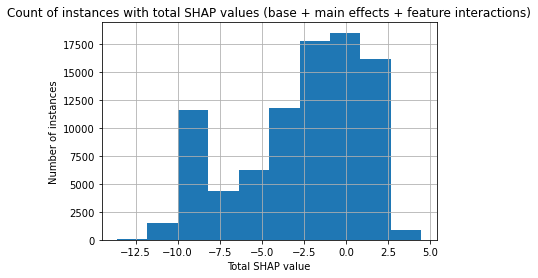

In [38]:
plt.hist(total_shap_per_instance)
plt.xlabel("Total SHAP value")
plt.ylabel("Number of instances")
plt.title("Count of instances with total SHAP values (base + main effects + feature interactions)")
plt.grid()
#plt.savefig('./output/scatter_plot_hosp_shap_vs_10k_thrombolysis.jpg', dpi=300,
#    bbox_inches='tight', pad_inches=0.2)

plt.show()

## How the SHAP main effect (or interaction) varies across the instances: using violin plots

### SHAP main effect of Infarction-Infarction

For this example lets focus on the feature "Infarction". This feature has two possible values: Infarction (1) and Haemorrhage (0).

From the histogram in the matrix showing the main effect for the feature Infarction, we can see that there are ~?? instances with a main effect of about 0.1, and ~?? instances with a main effect of about -7.

From this we can not see which of these instances are which stroke type (infarction of haemmorhage).

Here we will plot this same data using a violin plot, a violin for each streok type.

We can see from the violin plot that the main effect (infarction-infacrtion) is quite different depending on whether the instance is haemorrhage (a negative SHAP main effect value) or infarction (a positive SHAP main effect value).

This means that the feature will contribute a small likelihood of thrombolysis if the instance is infarction, and a strong likelihood of not having thrombolysis if the instance is haemorrhage. This matches the story that we took from the beeswarm plot of the SHAP values, however as we have now extracted just the main effect the violin plot is showing a distinct effect for gender. That means that the points on the beeswarm that join up these two distinct groups are from the feature interactions - they "muddy" the relationship (blur the edges, say) between the feature value and SHAP value. 

In [39]:
def plot_violin_shap_interaction(X, shap_interaction, main_feature, 
                                 interaction_feature):
    """
    Given the two features (main_feature and interaction_feature), plot the SHAP 
    interations as violin plots. 
    The main_feature will have it's data values displayed on the x axis. 
    The interaction_feature determines the SHAP interaction values that are 
    displayed in the violins.
    If the same feature name is in both (main_feature and interaction_feature)
    then the main effect will be displayed.
    
    X [pandas dataframe]: Feature per column, instance per row
    shap_interaction [3D numpy array]: [instance][feature][feature]
    main_feature [string]: feature name
    interaction_feature [string]: feature name
    
    """
    # Get the unqiue categories for the main feature
    category_list = list(X[main_feature].unique())

    # Setup dictionary and keys (key for each category, each key will hold a 
    #   list of SHAP interaction values for that category)
    shap_interaction_by_category_dict = {}
    for i in category_list:
        shap_interaction_by_category_dict[i]=[]
    
    # Store number of instances and number of categories
    n_instances = X.shape[0]
    n_categories = len(category_list)
    
    # For each instance put its instance interaction value in the corresponding 
    #   list (based on the instances category for the main feature)
    for i in range(n_instances):
        # Identify the instances category for the main feature
        category = X.iloc[i][main_feature]

        # Get the SHAP interaction value for the instance
        instance_interaction = pd.DataFrame(
            shap_interaction[i],index=X.columns,columns=X.columns)
        
        # Get the feature pairing interaction value
        value = instance_interaction.loc[main_feature][interaction_feature]

        # Store value in the dictionary using category as the key
        shap_interaction_by_category_dict[category].append(value)
    
    # Set violin width relative to count of instances
    width = [(len(shap_interaction_by_category_dict[category])/n_instances) 
             for category in category_list]

    # Create list of series to use in violin plot (one per violin)
    shap_per_category = [pd.Series(shap_interaction_by_category_dict[category]) 
                         for category in category_list]
    
    # create violin plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.violinplot(shap_per_category, showmedians=True, widths=width, )

    # customise the axes
    ax.set_title("")
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=90, fontsize=12)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(
        f'SHAP interaction value for {main_feature}-{interaction_feature}',
        fontsize=12)
    ax.set_xlabel(f'Feature: {main_feature}', fontsize=12)

    plt.subplots_adjust(bottom=0.15, wspace=0.05)

    # Add line at Shap = 0
    ax.plot([0, n_categories + 1], [0,0],c='0.5')
    
    return()

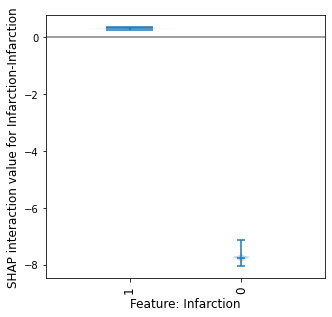

In [40]:
plot_violin_shap_interaction(X_combined, shap_interaction_combined, "Infarction", "Infarction");

### SHAP interaction of Infarction-precise

We can also see the range of the SHAP interaction value between the features male-Pclass (divided by the male categories).

This shows that for females the SHAP interaction value between male-Pclass ranges from -0.6 to 0.9, and for males it has a smaller range (-0.6 to 0.3). Since this is in addition to the main effect (for which all females had a strong likelihood to survive), for some females their likelihood for surviving is further increased, whereas for others their likelihood for surviving is reduced - but never enough to have a likelihood of not surviving. Remember that we'd need to add on all of the other SHAP interations to get the likelihood of surviving for females.

()

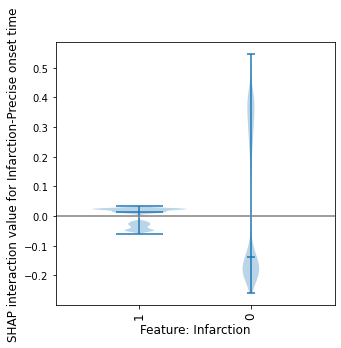

In [41]:
plot_violin_shap_interaction(X_combined, shap_interaction_combined, "Infarction", "Precise onset time")#"Arrival-to-scan time");

Violin plots can only display the values for one of the features in a feature-pairing - by it's placement on the x axis. In the violin plot above we can only see the value for the feature male, but not the value for the feature Pclass.

This can be solved by using a SHAP dependency plot - they can show the values for both features and the SHAP interaction value. This is shown in the following section, and we will introduce them using the same data as used in these two violin plots.

## How the SHAP main effect (or interaction) varies across the instances: using dependence plots

### SHAP main effect of infarction-infarction

We can see from the violin plot that the main effect (infarction-infarction) is quite different depending on whether the instance is male (a negative SHAP main effect value) or female (a positive SHAP main effect value).

This means that the feature will contribute a strong likelihood of survival if the instance is female, and a mid-strong likelihood of not surviving if the instance is male.

A dependence plot of the same data that's in the violin plot will represent it as individual points, instead of as a distribution. Doing so, it will plot all of the points on two points on the x axis: 0 for female, and 1 for male. A lot of information is lost due to overlap. To see more detail we add some jitter to the x-axis to spread the points out and so we cna get a sense of the density of the points in relation to the y value.

Here we see the same information as in the violin plot: the main effect (male-male) is quite different depending on whether the instance is male (a negative SHAP main effect value) or female (a positive SHAP main effect value).

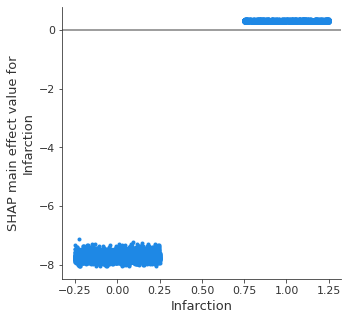

In [42]:
feature_name = "Infarction"

fig = plt.figure()
ax = fig.add_subplot()
shap.dependence_plot(
    (feature_name, feature_name),
    shap_interaction_combined, X_combined,
    display_features=X_combined,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X[feature_name].nunique()
ax.plot([-1, n_violins + 1], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(5)

plt.show()

### SHAP interaction of Infarction-Precise

A hinderence of using a violin plot to show the data for the SHAP interaction of a feature pair is that we can only show one of the feature values (on the x axis). 

When using a dependence plot to show the data for the SHAP interaction of a feature pairing we can display both of the feature values: the point location on the x axis shows the value of one of the features, and the colour of the point shows the value of the other feature.

Note: The SHAP interaction for feature pairings (e.g. male-Pclass) is splt between male-Pclass and Pclass-male. The total SHAP interaction is therefore 2* the individual interactions. We could multiply the interation by 2 to get the full SHAP interaction. Here we will plot both permutations and acknowledge that it's the sum of the pair (LHS shows columns as male and colour as Pclass. RHS shows columns as Pclass and colour as male). Each graph contains the exact same data points, and it is possible to match up the identical block of data points across the graphs. For example the purple points in the LHS graph represent the Pclass 2, and we can see that for these points they have a positive SHAP interaction value for female (x-axis 0) and negative SHAP interaction value for male (x-axis 1). We can see these two blocks of purple points in the RHS graph, with both blocks now aligned on the x-axis with value 2, and now coloured blue for female (with positive SHAP interaction value) or red for male (with negative SHAP interaction value).

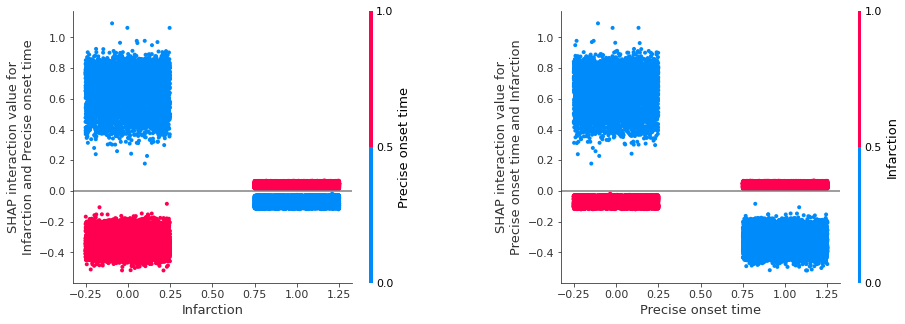

In [43]:
f1 = "Infarction"
f2 = "Precise onset time"

fig = plt.figure()
ax = fig.add_subplot(121)
shap.dependence_plot(
    (f1, f2),
    shap_interaction_combined, X_combined,
    display_features=X_combined,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X[f1].nunique()
ax.plot([-1, n_violins + 1], [0,0],c='0.5') 

ax1 = fig.add_subplot(122)
shap.dependence_plot(
    (f2, f1),
    shap_interaction_combined, X_combined,
    display_features=X_combined,
    x_jitter=0.5,
    ax=ax1,
    show=False)

# Add line at Shap = 0
n_violins = X[f2].nunique()
ax1.plot([-1, n_violins + 1], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=.4)

plt.show()

## Grid of SHAP dependence plots

We will now show all of the SHAP interaction values in a grid of plots: each row and column represents a feature.

The diagonal graphs show the SHAP main effect for each feature. The SHAP interactions between features are off the diagonal, these are split symetrically (eg. age-male == male-age).

The SHAP main effect for feature male is shown in the top left (position [0, 0]). As already discussed, this shows that when the feature value is female, this has a strong contribution to the models prediction that the passenger will survive. And when this feature value is male there is a mid-strong contribution that the passenger will not survive.

The plot in position [1,1] shows the SHAP main effect for class. This shows that first class contributes a strong likelihood to survive, second class does not have much contribution, and third class contributes a strong likelihood not to survive.

But on top of these main effects we can see the contributon from the interation of these features. This is shown in positions [0, 1] and [1, 0]. The SHAP interaction between male and Pclass, and Pclass and male.

Graph in grid position [0, 1] (first row, second column) shows the SHAP interaction between male and Pclass, the data has been split into columns by the value of the gender feature (female on left, male on right), and the colour represents the class feature (first class = blue, second class = purple, third class = red). The value represents the contribution to the likelihood of this passenger surviving due to this combination of values - this is in addition to the main effect that we saw in the top left.

It can be seen that passengers in first or second class further increase the likelihood of survival for females, and not surviving for males, as the SHAP interation value is in the same sign to the SHAP main effect: A female passenger in first or second class will increase the likelihood of survival from the models prediction, and so will further help your survival in addition to the fact that you are female (as we saw in the SHAP main effect); similarly a male passenger in first or second class will increase the likelihood of not surviving, and so will further contribute to the likelihood that you will not survive, in addition to the fact that you are male (as we saw in the SHAP main effect).
However the converse is true for passengers in third class, as the SHAP interaction value is in the opposite sign to the SHAP main effect. A female passenger in third class will have a negative contribution to the survival (but remember that the main effect for female is a strong likelihood to survive), and if you are male in third class this combination will have a positive contribution to your survival (but remember that the main effect for male is a mid-strong likelihood to not survive).

The grid of dependency graphs are a mirror image across the diagonal. Meaning that the same data is shown in position [0,1] as in [1,0] just with the feature being displayed in the column or by colour is switched over.

Looking at the graph in position [1, 0] (second row, first column) shows the identical SHAP interation values for the features male - PClass, as we have just discussed above. Now the columns are per class (first, second, third) and the colour is by gender (male, female). Here we see that for first and second class females contributes that there is a mid likelihood to not survive, whereas if male then contributes a positive likelihood to survive. But that this is opposite for third class, where is it the females (red) with a positive likelihood to survive. This is also on top of the main effect from Pclass.

Resources used to make the grid of dependence plots: https://stackoverflow.com/questions/58510005/python-shap-package-how-to-plot-a-grid-of-dependence-plots \
(for future reference, but not yet used here: https://gist.github.com/eddjberry/3c1818a780d3cb17390744d6e215ba4d)

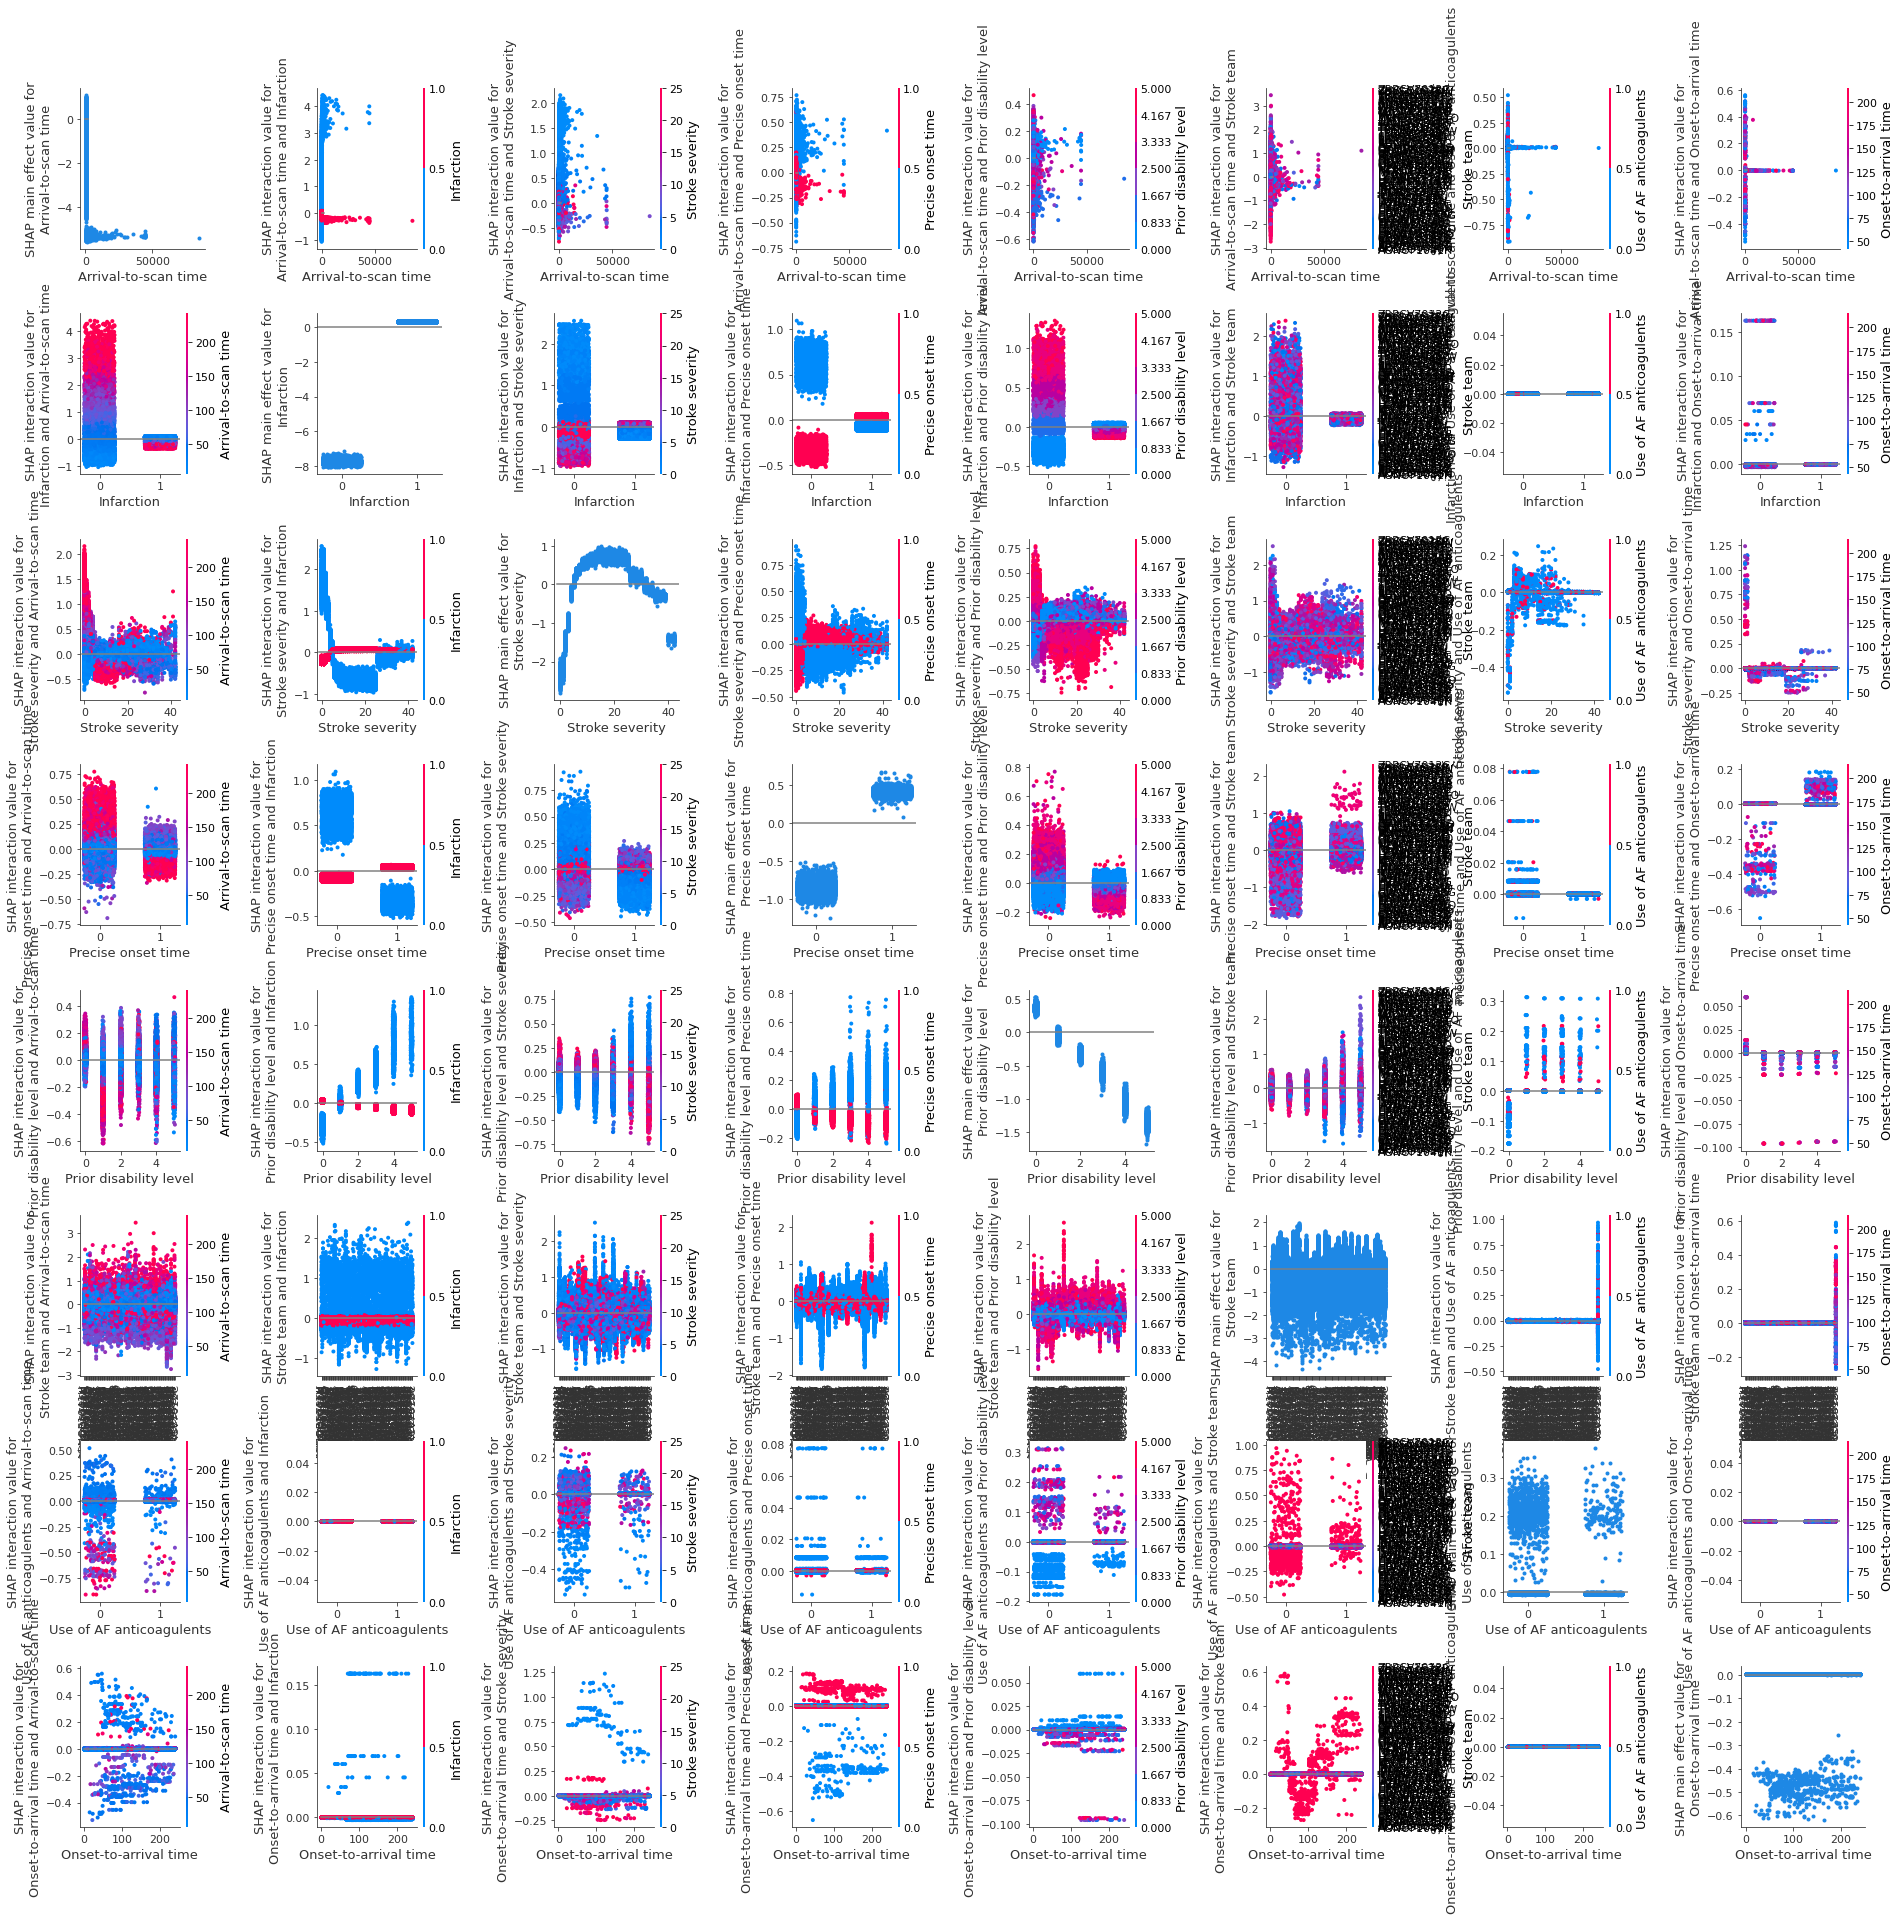

In [44]:
# Get feature names
features = X_combined.columns

# Set up the matrix of subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()

# Plot each SHAP independence (and main effect on diagonal)
count = 0
for f1 in features:
    for f2 in features:
        
        # Add more jitter the fewer categories the feature has
        n_categories = X_combined[f1].nunique()
        x_jitter = max(0, 0.7 - (n_categories * 0.1))
            
        # Plot data
        shap.dependence_plot(
            (f1, f2), shap_interaction_combined, X_combined, x_jitter=x_jitter, 
            display_features=X_combined, show=False, ax=axes[count])
        
        # Add line at Shap = 0
        n_classes = X_combined[f1].nunique()
        axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   
        count += 1

# Visual properties of figure
dimension = 4 * n_features
fig.set_figheight(dimension)
fig.set_figwidth(dimension)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)
plt.show()

Using the individual instance values you can unpick and understand how each instance gets their classification.

Each instance is represented in the grid of SHAP depencency plots, and so this shows all of the relationships that the model uses to derive it's predictions for the whole dataset. 

## Other SHAP plotting options

The SHAP library also offers other plotting options, such as a summary plot based on the beeswarm plot. 

We will show it here for completeness, however we found it to be tricky to interprete, and left gaps in our understanding of the relationships (it left us with further questions). 

It was due to this that we created our grid of dependency plots (as displayed above).

### SHAP interactions summary plot (a grid of beeswarms)

The beeswarm plot above showed the overall SHAP value for the feature. This next plot (a grid of beeswarms) shows the SHAP main effect and SHAP interactions for each feature. Each row and column represents a feature. The beeswarms on the diagonal represent the SHAP main effect for that feature, and those off the diagonal represent the SHAP interations with the other features.


The graphs are symmetrical around the diagonal, and so the shape of the data in the corresponding graph about the diagonal are the same, however the points are coloured based on the value of the feature represented by the row. For example, the first row this showing the feature male, so red represents the value male, and blue represents the value female. The second row shows the feature Pclass where blue represents first class, purple represents second class, and red represents third class. The third row shows the feature Age where blue represents the youngest, purple represent middle aged and red represents oldest. The fourth row shows the feature SibSp where blue represents no siblings, purple represents 3-4 siblings, and red represents seven siblings.

The shape of the data is based on the density of points that have the SHAP interaction value as displayed on the x axis. 

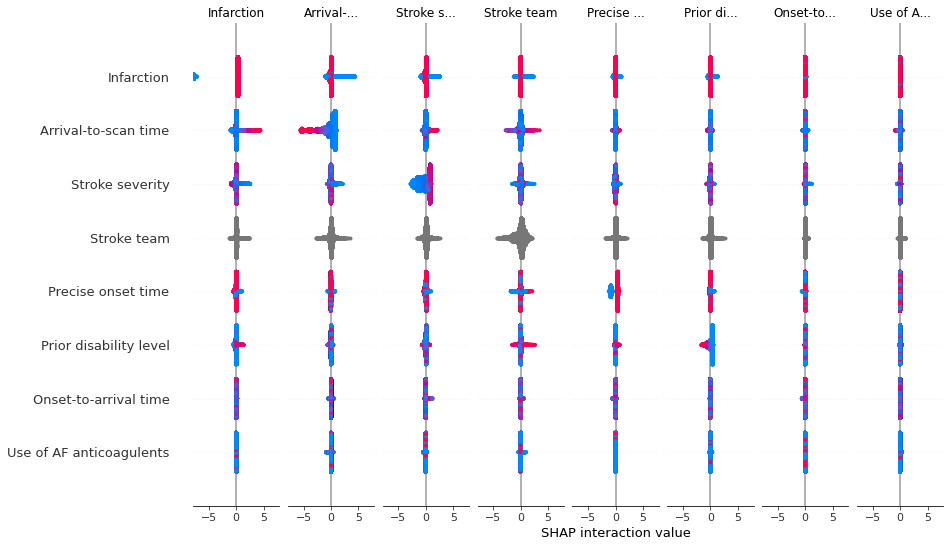

In [46]:
#Display summary plot
shap.summary_plot(shap_interaction_combined, X_combined, show=False, max_display=8)

## Observations

* SHAP interactions are awesome! 
* Viewing them as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset.

EXTRA CODE

shap_attended_hospital = []
shap_not_attend_these_hospitals = []

# SHAP values for all hospitals
df_hosp_shap_values["all_stroke_teams"] = df_hosp_shap_values.sum(axis=1)

# Through each patient and get their stroke team
for row in X_combined["Stroke team"]

    stroke_team = X_combined["Stroke team"].iloc[row]
    # SHAP value for their stroke team attended
    shap_attended_hospital.append(df_hosp_shap_values[f"team_{i}"].iloc[row])
    
    sum_rest = df_hosp_shap_values["all_stroke_teams"] - df_hosp_shap_values[f"team_{i}"]
    shap_not_attend_these_hospitals.append(sum_rest)
    
    
    
shap_attended_hospital = []
shap_not_attend_these_hospitals = []
for i in X_combined["Stroke team"]
#    X[f"team_{X_combined['Stroke team'].iloc[3]}"]
    shap_attended_hospital.append(X[f"team_{i}"])
    
    
    sum_all_hosp_shap = shap_attended_hospital.append(X[f"team_{i}"])
    shap_not_attend_these_hospitals.append((X[f"team_{i}"]))
    
# X_combined has the original Stroke team column
# X has the one hot
# Want to extract the values for the relevant column per patient for the hosptial that they attended.
# Sum the rest

shap_attended_hospital = pd.series()

for i in X_combined["Stroke team"].unique()
#    X[f"team_{X_combined['Stroke team'].iloc[3]}"]
    X[f"team_{i}"]

X[f"team_{X_combined['Stroke team'].iloc[3]}"].sum()
X_combined['Stroke team']
X_combined['Stroke team'].iloc[3]